# Packages

In [63]:
import pandas as pd
import numpy as np
import os, re, csv, codecs, operator, sys, gc
from collections import defaultdict, OrderedDict
import importlib
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import lightgbm as lgb
from itertools import repeat
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from textblob import TextBlob    # For pos-tagging
from scipy.sparse import csr_matrix, hstack
from scipy.special import logit, expit

from keras import optimizers, initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Lambda, Embedding, Dropout, Activation, SpatialDropout1D, Reshape, \
GlobalAveragePooling1D, merge, Flatten, Bidirectional, CuDNNGRU, add, Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine import InputSpec, Layer
from keras import backend as K

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

# Parameters

In [2]:
PATH = 'datasets/'
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
FAST_TEXT_EMBEDDING = 'pretrain_embedding/crawl-300d-2M.vec'
GLOVE_EMBEDDING = 'pretrain_embedding/glove.840B.300d.txt'
CLEAN_WORD_PATH = None
TRAIN_DATA_FILE = 'train.csv'
TEST_DATA_FILE = 'test.csv'
MAX_SEQUENCE_LENGTH = 350
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300
FOLD_COUNT = 10
BATCH_SIZE = 200

# Load Pretrain Models

In [3]:
def load_pretrain_embedding(file):
    """
    Return a dictionary whose key is word, value is pretrained word embedding.
    """
    print('Indexing word vectors')
    embeddings_index = {}
    f = open(file, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        try:
            word = values[0]
            coefs = np.array(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            print("Error on: ", values[:3])
    f.close()
    print("Total %s word vectors" % len(embeddings_index))
    return embeddings_index

In [4]:
def load_clean_words(file):
    """
    Return a dictionary whose key is typo, value is correct word.
    """
    clean_word_dict = {}
    with open(file, 'r', encoding='utf-8'):
        for line in f:
            line = line.strip('\n')
            typo, correct = line.split(',')
            clean_word_dict[typo] = correct
    return clean_word_dict

In [5]:
embeddings_index = load_pretrain_embedding(FAST_TEXT_EMBEDDING)

Indexing word vectors
Total 2000000 word vectors


In [6]:
glove_embeddings_index = load_pretrain_embedding(GLOVE_EMBEDDING)

Indexing word vectors
Error on:  ['.', '.', '.']
Error on:  ['at', 'name@domain.com', '0.0061218']
Error on:  ['.', '.', '.']
Error on:  ['to', 'name@domain.com', '0.33865']
Error on:  ['.', '.', '0.035974']
Error on:  ['.', '.', '.']
Error on:  ['email', 'name@domain.com', '0.33529']
Error on:  ['or', 'name@domain.com', '0.48374']
Error on:  ['contact', 'name@domain.com', '0.016426']
Error on:  ['Email', 'name@domain.com', '0.37344']
Error on:  ['on', 'name@domain.com', '0.037295']
Error on:  ['At', 'Killerseats.com', '-0.13854']
Error on:  ['by', 'name@domain.com', '0.6882']
Error on:  ['in', 'mylot.com', '-0.18148']
Error on:  ['emailing', 'name@domain.com', '0.39173']
Error on:  ['Contact', 'name@domain.com', '0.14933']
Error on:  ['at', 'name@domain.com', '0.44321']
Error on:  ['•', 'name@domain.com', '-0.13288']
Error on:  ['at', 'Amazon.com', '-0.5275']
Error on:  ['is', 'name@domain.com', '-0.1197']
Total 2195885 word vectors


# Data Overview

In [7]:
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

In [ ]:
train_df.corr()

In [ ]:
train_df.head()

In [8]:
train_comments = train_df['comment_text'].values
test_comments = test_df['comment_text'].values
train_comments_lengths = [len(s) for s in train_comments]
test_comments_lengths = [len(s) for s in test_comments]

In [ ]:
def explore_comments(arr):
    print("MAX LENGTH:\t\t", np.max(arr))
    print("AVG LENGTH:\t\t", np.average(arr))
    print("MIN LENGTH:\t\t", np.min(arr))
    print("STANDARD DIVISION:\t", np.std(arr))
    print("RANGE:\t\t\t", np.min(arr), " to ", np.average(arr) + 2 * np.std(arr))
    
print("------Train------")
explore_comments(train_comments_lengths)

print("------Test------")
explore_comments(test_comments_lengths)

In [ ]:
for class_name in list_classes:
    print('{}\n{}\n'.format(class_name, train_df[class_name].value_counts()))

In [9]:
def count_regexp_occ(regexp='', text=None):
    """
    Simple way to calculate the number of occurence of a regex
    """
    if len(text) == 0:
        return 0
    else:
        return len(re.findall(regexp, text)) / len(text)

# Data Cleaning

## Load Cleaned Words

In [10]:
if CLEAN_WORD_PATH == None:
    ignored_words = set(stopwords.words('english'))
else:
    ignored_words = load_clean_words(CLEAN_WORD_PATH)

## Ensemble Features

In [11]:
feature_files = sorted([f for f in listdir('datasets/feature_files/') if isfile(join('datasets/feature_files/', f))])
for file in feature_files:
    fixed_df = pd.read_csv('datasets/feature_files/' + file)
    train_df = train_df.merge(fixed_df, on='id', how='left')
    test_df = test_df.merge(fixed_df, on='id',how='left')

In [12]:
def ensemble_data(path):
    files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    for i, file in enumerate(files):
        temp_df = pd.read_csv(path + file)
        print('Datasets before ensemble null number:', temp_df.isnull().sum().sum())
        if i == 0:
            ensembled = temp_df
        else:
            ensembled = ensembled.merge(temp_df, on='id', how='left')
            print('Datasets after ensemble null number:', ensembled.isnull().sum().sum())
    
    column_numbers = ensembled.shape[1]
    toxic = ensembled.iloc[:, [i for i in range(2, column_numbers, len(list_classes))]]
    severe_toxic = ensembled.iloc[:, [i for i in range(3, column_numbers, len(list_classes))]]
    obscene = ensembled.iloc[:, [i for i in range(4, column_numbers, len(list_classes))]]
    threat = ensembled.iloc[:, [i for i in range(5, column_numbers, len(list_classes))]]
    insult = ensembled.iloc[:, [i for i in range(6, column_numbers, len(list_classes))]]
    identity_hate = ensembled.iloc[:, [i for i in range(7, column_numbers, len(list_classes))]]
    
    return toxic, severe_toxic, obscene, threat, insult, identity_hate

In [13]:
train_toxic, train_severe_toxic, train_obscene, train_threat, train_insult, train_identity_hate = ensemble_data('datasets/ensemble_files/train/')
test_toxic, test_severe_toxic, test_obscene, test_threat, test_insult, test_identity_hate = ensemble_data('datasets/ensemble_files/test/')

Datasets before ensemble null number: 0
Datasets before ensemble null number: 0
Datasets after ensemble null number: 0
Datasets before ensemble null number: 0
Datasets after ensemble null number: 0
Datasets before ensemble null number: 0
Datasets after ensemble null number: 0
Datasets before ensemble null number: 0
Datasets before ensemble null number: 0
Datasets after ensemble null number: 0
Datasets before ensemble null number: 0
Datasets after ensemble null number: 0
Datasets before ensemble null number: 0
Datasets after ensemble null number: 0


## Regex Regularization

In [15]:
# Regex to remove all Non-Alpha Numeric and space
special_character_removal = re.compile(r'[^?!.,:a-z\d ]', re.IGNORECASE)
# Regex to remove all numerics
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

word_count_dict = defaultdict(int)

def clean_datasets(text, remove_stopwords=False, stem_words=False, count_null_words=True, clean_wiki_tokens=True):
    
    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)
    
    if clean_wiki_tokens:
        text = re.sub(r"\.jpg", " ", text)
        text = re.sub(r"\.png", " ", text)
        text = re.sub(r"\.gif", " ", text)
        text = re.sub(r"\.bmp", " ", text)
        text = re.sub(r"\.pdf", " ", text)
        text = re.sub(r"image:", " ", text)
        text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
        
        text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
        text = re.sub(r"\[?\[user:.*\]", " ", text)
        text = re.sub(r"\[?\[user:.*\|", " ", text)
        text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
        text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
        text = re.sub(r"\[?\[special:.*\]", " ", text)
        text = re.sub(r"\[?\[special:.*\|", " ", text)
        text = re.sub(r"\[?\[category:.*\]", " ", text)
        text = re.sub(r"\[?\[category:.*\|", " ", text)
        
        text = re.sub(r"wp:", " ", text)
        text = re.sub(r"file:", " ", text)
    
    # For Punctuation
    text = re.sub(r"”", "\"", text)
    text = re.sub(r"“", "\"", text)
    text = re.sub(r"´", "'", text)
    text = re.sub(r"—", " ", text)
    text = re.sub(r"’", "'", text)
    text = re.sub(r"‘", "'", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"−", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"#", " # ", text)
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"<3", " love ", text)
        
    text = replace_numbers.sub('', text)
    
    if remove_stopwords:
        for typo, correct in ignored_words.items():
            text = re.sub(typo, correct, text)
    
    if count_null_words:
        text = text.split()
        for t in text:
            word_count_dict[t] += 1
        text = " ".join(text)
        
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
        
    return text

In [16]:
list_sentences_train = train_df['comment_text'].fillna('no comment').values
list_sentences_test = test_df['comment_text'].fillna('no comment').values
train_labels = train_df[list_classes].values

In [17]:
cleaned_train_comments, cleaned_test_comments = [], []
print('Processing data cleaning...')

for text in list_sentences_train:
    cleaned_train_comments.append(clean_datasets(text))
for text in list_sentences_test:
    cleaned_test_comments.append(clean_datasets(text))
print('Done!')

Processing data cleaning...
Done!


In [18]:
train_df['comment_text_cleaned'] = cleaned_train_comments
test_df['comment_text_cleaned'] = cleaned_test_comments

## Create Meta (Extend) Features

In [19]:
def count_unknown_embedding(t, idx):
    t = t.split()
    res = 0
    for word in t:
        if word not in idx.keys():
            res += 1
    return res

In [20]:
def create_meta_feature(df):
    df['total_length'] = df['comment_text'].apply(len)
    df['capital'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capital']) / float(row['total_length']), axis=1)
    df["unknown_glove"] = df['comment_text_cleaned'].apply(lambda x: count_unknown_embedding(x, glove_embeddings_index))
    df["unknown_fasttext"] = df['comment_text_cleaned'].apply(lambda x: count_unknown_embedding(x, embeddings_index))
    df["unknown_glove_fasttext"] = df["unknown_glove"] + df["unknown_fasttext"]
    # Special Expressions Collection
    df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df["ant_slash_n"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\n", x))
    df["start_with_columns"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"^\:+", x))
    df["has_emphasize_equal"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\={2}.+\={2}", x))
    df["has_emphasize_quotes"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\"{4}\S+\"{4}", x))
    df["has_star"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\*", x))
    ## Check for dates
    df["has_timestamp"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
    df["has_date_long"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))    # example: 18:44, 8 December 2010
    df["has_date_short"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))
    ## Check for http links
    df["has_http"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    df["has_ip"] = df["comment_text"].apply(lambda x: count_regexp_occ("(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", x))
    ## Check for mail
    df["has_mail"] = df["comment_text"].apply(lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x))
    ## Check for image
    df["has_image"] = df["comment_text"].apply(lambda x: count_regexp_occ(r'image\:', x))
    # Dirty Languages Collection
    df["nb_fk"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff]\S{2}[Kk]", x))
    df["nb_sk"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dk"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    df["nb_you"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))

In [21]:
print("Creating meta features...")
create_meta_feature(train_df)
create_meta_feature(test_df)
print('Done!')

Creating meta features...
Done!


In [22]:
train_cols = train_df.columns[9:]
print(train_cols)
column_numbers = len(train_df.columns)
print(column_numbers, len(train_cols))

Index(['total_length', 'capital', 'caps_vs_length', 'unknown_glove',
       'unknown_fasttext', 'unknown_glove_fasttext', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_symbols', 'num_words',
       'num_unique_words', 'words_vs_unique', 'num_smilies', 'ant_slash_n',
       'start_with_columns', 'has_emphasize_equal', 'has_emphasize_quotes',
       'has_star', 'has_timestamp', 'has_date_long', 'has_date_short',
       'has_http', 'has_ip', 'has_mail', 'has_image', 'nb_fk', 'nb_sk',
       'nb_dk', 'nb_you', 'nb_mother', 'nb_ng'],
      dtype='object')
41 32


In [23]:
for col in train_cols:
    train_toxic[col] = train_df[col]
    train_severe_toxic[col] = train_df[col]
    train_obscene[col] = train_df[col]
    train_threat[col] = train_df[col]
    train_insult[col] = train_df[col]
    train_identity_hate[col] = train_df[col]
for col in train_cols:
    test_toxic[col] = test_df[col]
    test_severe_toxic[col] = test_df[col]
    test_obscene[col] = test_df[col]
    test_threat[col] = test_df[col]
    test_insult[col] = test_df[col]
    test_identity_hate[col] = test_df[col]
train_ensembled_data = [train_toxic, train_severe_toxic, train_obscene, train_threat, train_insult, train_identity_hate]
test_ensembled_data = [test_toxic, test_severe_toxic, test_obscene, test_threat, test_insult, test_identity_hate]

In [25]:
del list_sentences_train, list_sentences_test
gc.collect()

211

# Data Preprocessing

In [26]:
all_comment_text = pd.concat([train_df['comment_text_cleaned'], test_df['comment_text_cleaned']], axis=0).fillna("unknown")
nrow_train = train_df.shape[0]
all_comment_text.shape[0]

312735

In [27]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
data = vectorizer.fit_transform(all_comment_text)
print(data.shape)

(312735, 50000)


In [28]:
norm_data = MaxAbsScaler().fit_transform(data)
print(norm_data.shape)

(312735, 50000)


## Tf-idf Feature Extraction

## Word-Level

In [29]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=20000
)
word_vectorizer.fit(all_comment_text)
train_word_features = word_vectorizer.transform(cleaned_train_comments)
test_word_features = word_vectorizer.transform(cleaned_test_comments)
print('Word vectorization process Done!')

Word vectorization process Done!


## Char-Level

In [31]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 6),
    max_features=30000
)
char_vectorizer.fit(all_comment_text)
train_char_features = char_vectorizer.transform(cleaned_train_comments)
test_char_features = char_vectorizer.transform(cleaned_test_comments)
print('Char vectorization process Done!')

Char vectorization process Done!


## Features Aggregation

In [32]:
del all_comment_text
gc.collect()

0

In [33]:
train_tfidf_features = hstack([train_char_features, train_word_features]).tocsr()
test_tfidf_features = hstack([test_char_features, test_word_features]).tocsr()

In [34]:
del train_char_features, train_word_features, test_char_features, test_word_features
gc.collect()

0

## Build Vocabulary & Tokenizer

In [35]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='"#$%&()+,-./:;<=>@[\\]^_`{|}~\t\n')

In [36]:
print('Automatically train vocab & tokenizer...')
tokenizer.fit_on_texts(cleaned_train_comments + cleaned_test_comments)

train_sequences = tokenizer.texts_to_sequences(cleaned_train_comments)
test_sequences = tokenizer.texts_to_sequences(cleaned_test_comments)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train_data tensor: ', train_data.shape)
print('Shape of train_label tensor: ', train_labels.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor: ', test_data.shape)

Automatically train vocab & tokenizer...
Found 330549 unique tokens
Shape of train_data tensor:  (159571, 350)
Shape of train_label tensor:  (159571, 6)
Shape of test_data tensor:  (153164, 350)


## Pos Feature Extraction

In [37]:
def sent2pos(sentence):
    try:
        tag = TextBlob(sentence).tags
    except:
        print(sentence)
        
    updated_sentence = ' '.join([i[0] for i in tag])
    tagged = ' '.join([i[1] for i in tag])
    return updated_sentence, tagged

In [38]:
inverse_word_index = {v: k for k, v in word_index.items()}

In [39]:
Pos_comments = []
Pos_updated_sentence = []
for text in tqdm(train_sequences):
    text_ = ' '.join([inverse_word_index[word] for word in text])    # convert to word format
    if not isinstance(text_, str):
        print(text, '\n', text_)
    updated_sentence, tags = sent2pos(text_)
    Pos_updated_sentence.append(updated_sentence)
    Pos_comments.append(tags)
    assert len(updated_sentence.split(' ')) == len(tags.split(' ')), "T1 {} T2 {}".format(len(text), len(tags.split()))
    
Pos_test_comments = []
Pos_test_updated_sentence = []
for text in tqdm(test_sequences):
    text_ = ' '.join([inverse_word_index[word] for word in text])
    updated_test_sentence, test_tags = sent2pos(text_)
    Pos_test_updated_sentence.append(updated_test_sentence)
    Pos_test_comments.append(test_tags)
    assert len(updated_test_sentence.split(' ')) == len(test_tags.split(' ')), "T1 {} T2 {}".format(len(text), len(test_tags.split()))

100%|██████████| 153164/153164 [09:06<00:00, 280.46it/s]


In [40]:
pos_tokenizer = Tokenizer(num_words=50, filters='"#$%&()+,-./:;<=>@[\\]^_`{|}~\t\n')

In [41]:
print('Automatically train pos tokenizer...')
pos_tokenizer.fit_on_texts(Pos_comments + Pos_test_comments)

train_pos_sequences = pos_tokenizer.texts_to_sequences(Pos_comments)
test_pos_sequences = pos_tokenizer.texts_to_sequences(Pos_test_comments)

pos_word_index = pos_tokenizer.word_index
print('Found %s unique tokens' % len(pos_word_index))

pos_train_data = pad_sequences(train_pos_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pos_train_data.shape)

pos_test_data = pad_sequences(test_pos_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor:', pos_test_data.shape)

Automatically train pos tokenizer...
Found 34 unique tokens
Shape of data tensor: (159571, 350)
Shape of test_data tensor: (153164, 350)


## Second time valid for tokenzier

In [42]:
print('Automatically train pos tokenizer secondly...')
cleaned_train_comments, cleaned_test_comments = [], []
for text in Pos_updated_sentence:
    cleaned_train_comments.append(clean_datasets(text))
for text in Pos_test_updated_sentence:
    cleaned_test_comments.append(clean_datasets(text))
    
train_sequences = tokenizer.texts_to_sequences(cleaned_train_comments)
test_sequences = tokenizer.texts_to_sequences(cleaned_test_comments)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train_data tensor:', train_data.shape)
print('Shape of train_label tensor:', train_labels.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test_data tensor:', test_data.shape)

Automatically train pos tokenizer secondly...
Found 330549 unique tokens
Shape of train_data tensor: (159571, 350)
Shape of train_label tensor: (159571, 6)
Shape of test_data tensor: (153164, 350)


In [43]:
train_df['cleaned_comment_text'] = cleaned_train_comments
test_df['cleaned_comment_text'] = cleaned_test_comments
train_df.to_csv(PATH + 'cleaned_train.csv', index=False)
test_df.to_csv(PATH + 'cleaned_test.csv', index=False)

In [44]:
del cleaned_train_comments, cleaned_test_comments
gc.collect()

14

## Sentence Embedding (Build a matrix)

In [45]:
print('Preparing embedding matrix...')
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

null_words = open(PATH + 'null_words.txt', 'w', encoding='utf-8')

for word, idx in word_index.items():
    if idx >= MAX_NB_WORDS:
        null_words.write(word + ', ' + str(word_count_dict[word]) + '\n')
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        null_words.write(word + ', ' + str(word_count_dict[word]) + '\n')
print('Null_word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix...
Null_word embeddings: 24244


In [46]:
print('Sorting null_words...')
null_dict = {}
with open(PATH + 'null_words.txt', 'r', encoding='utf-8') as nullword:
    for line in nullword:
        word, count = line.strip('\n').split(', ')
        null_dict[word] = int(count)

null_dict = sorted(null_dict.items(), key=operator.itemgetter(1), reverse=True)

with open(PATH + 'null_words.txt', 'w', encoding='utf-8') as output:
    for word, count in null_dict:
        output.write(word + ', ' + str(count) + '\n')
print('Sorting operation Done!')

Sorting null_words...
Sorting operation Done!


# Model Training

## Baseline Model with Using Tfidf Features

In [ ]:
kfold = KFold(n_splits=FOLD_COUNT, shuffle=False)
tfidf_models = []
for i, (train_idx, test_idx) in enumerate(kfold.split(train_tfidf_features)):
    print('## In fold {} ##'.format(i + 1))
    classifier = LogisticRegression(solver='sag', C=12.0)
    
    for class_name in list_classes:
        print('Processing {} ...'.format(class_name))
        train_target = train_df[class_name][train_idx]
        
        classifier.fit(train_tfidf_features[train_idx], train_target)
        y_pred = classifier.predict(train_tfidf_features[train_idx])
        
        print('Training accuracy is {}'.format(accuracy_score(y_pred, train_target)))
        
        val_target = train_df[class_name][test_idx]
        val_pred = classifier.predict(train_tfidf_features[test_idx])
        
        print('Validation accuracy is {}'.format(accuracy_score(val_pred, val_target)))
        
    tfidf_models.append(classifier)
print('K-fold cross validation Done!')

## Logistic Regression

In [ ]:
for i, model in enumerate(tfidf_models):
    print('## In Model {} ##'.format(i + 1))
    # predictions = {'id': test_df['id']}
    predictions = OrderedDict()
    predictions['id'] = test_df['id']
    
    for class_name in list_classes:
        predictions[class_name] = model.predict_proba(test_tfidf_features)[:, 1]
        print('Predict the proba for {} Done!'.format(class_name))
        print(predictions.keys())
    
    print(predictions.keys())
    submission = pd.DataFrame.from_dict(predictions)
    submission.to_csv('results/TFIDF_Based/TFIDF_Logistic_Regression_Submission_{}.csv'.format(i), index=False)

In [ ]:
result_list = ['results/TFIDF_Based/TFIDF_Logistic_Regression_Submission_{}.csv'.format(i) for i in range(0, FOLD_COUNT)]
bagging(result_list, 'results/TFIDF_Based/TFIDF_bagging.csv')
print('Bagging operation Done!')

## ExtraTreeClassifier

In [ ]:
accs = []
# et_predictions = {'id': test_df['id']}
et_predictions = OrderedDict()
et_predictions['id'] = test_df['id']

for class_name in list_classes:
    train_target = train_df[class_name]
    classifier = ExtraTreesClassifier(n_estimators=30)
    
    cv_score = np.mean(cross_val_score(classifier, train_tfidf_features, train_target, cv=10, scoring='roc_auc'))
    accs.append(cv_score)
    print('CV Score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(train_tfidf_features, train_target)
    et_predictions[class_name] = classifier.predict_proba(test_tfidf_features)[:, 1]
    
submission = pd.DataFrame.from_dict(et_predictions)
submission.to_csv('result/TFIDF_Based/TFIDF_ExtraTreesClassifier_Submission.csv', index=False)

## Light-GBM For Ensembled_Datasets

In [47]:
def fit_every_feature_model(feature_data, label, feature_name, feature_test_data, fold_count, predict=False):
    predictions = np.zeros(shape=(len(feature_test_data)))
    fold_size = len(feature_data) // fold_count
    
    print('Feature name is {}'.format(feature_name))
    auc_score = 0
    for fold_id in range(0, fold_count):
        print('## Fold In {} ##'.format(fold_id + 1))
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        if fold_id == fold_size - 1:
            fold_end = len(feature_data)
            
        train_x = np.concatenate((feature_data[:fold_start], feature_data[fold_end:]))
        train_y = np.concatenate((label[:fold_start], label[fold_end:]))
        
        val_x = feature_data[fold_start:fold_end]
        val_y = label[fold_start:fold_end]
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y)
        
        lgbm_model = lgb.LGBMClassifier(max_depth=5, metric='auc', n_estimators=10000, num_leaves=32, boosting_type='gbdt', \
                                       learning_rate=0.01, feature_fraction=0.3, bagging_fraction=0.8, bagging_freq=5, reg_lambda=0)
        lgbm_model.fit(X=train_x, y=train_y, eval_metric=['auc', 'binary_logloss'], eval_set=(val_x, val_y), early_stopping_rounds=1000, verbose=500)
        auc_score += lgbm_model.best_score_['valid_0']['auc']
        lgb.plot_importance(lgbm_model, max_num_features=30)
        plt.show()
        if predict:
            prediction = lgbm_model.predict_proba(feature_test_data)[:, 1]
            predictions += prediction
            del lgbm_model
    predictions /= fold_count
    print('Training LightGBM Done!')
    return predictions, auc_score / fold_count

Feature name is toxic
## Fold In 1 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.162518	valid_0's auc: 0.981651
[1000]	valid_0's binary_logloss: 0.16795	valid_0's auc: 0.981667
Early stopping, best iteration is:
[472]	valid_0's binary_logloss: 0.161668	valid_0's auc: 0.981627


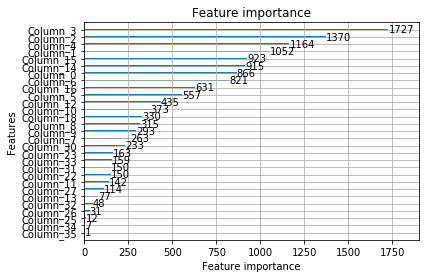

## Fold In 2 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.066613	valid_0's auc: 0.993663
[1000]	valid_0's binary_logloss: 0.061076	valid_0's auc: 0.993759
[1500]	valid_0's binary_logloss: 0.0608471	valid_0's auc: 0.993734
[2000]	valid_0's binary_logloss: 0.0609328	valid_0's auc: 0.993703
Early stopping, best iteration is:
[1273]	valid_0's binary_logloss: 0.0607956	valid_0's auc: 0.993767


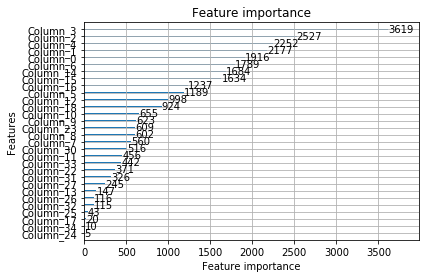

## Fold In 3 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0535597	valid_0's auc: 0.995987
[1000]	valid_0's binary_logloss: 0.0491909	valid_0's auc: 0.995983
[1500]	valid_0's binary_logloss: 0.0496871	valid_0's auc: 0.995901
Early stopping, best iteration is:
[684]	valid_0's binary_logloss: 0.0497805	valid_0's auc: 0.99602


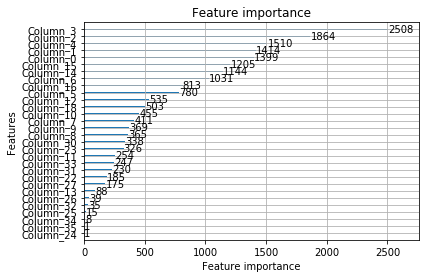

## Fold In 4 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.049429	valid_0's auc: 0.996364
[1000]	valid_0's binary_logloss: 0.044236	valid_0's auc: 0.996445
[1500]	valid_0's binary_logloss: 0.0441356	valid_0's auc: 0.996452
[2000]	valid_0's binary_logloss: 0.0443061	valid_0's auc: 0.996442
Early stopping, best iteration is:
[1376]	valid_0's binary_logloss: 0.0440999	valid_0's auc: 0.996455


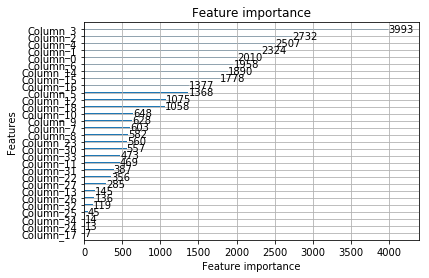

## Fold In 5 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0436761	valid_0's auc: 0.997431
[1000]	valid_0's binary_logloss: 0.0377499	valid_0's auc: 0.997501
[1500]	valid_0's binary_logloss: 0.0377988	valid_0's auc: 0.997497
[2000]	valid_0's binary_logloss: 0.0380476	valid_0's auc: 0.99749
Early stopping, best iteration is:
[1223]	valid_0's binary_logloss: 0.0377021	valid_0's auc: 0.997502


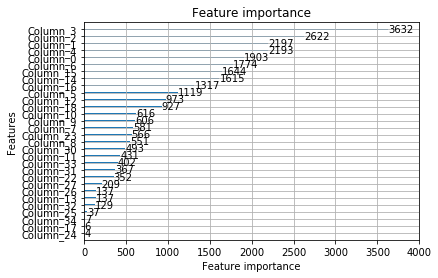

## Fold In 6 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0446095	valid_0's auc: 0.997503
[1000]	valid_0's binary_logloss: 0.0377966	valid_0's auc: 0.997573
[1500]	valid_0's binary_logloss: 0.0372405	valid_0's auc: 0.997591
[2000]	valid_0's binary_logloss: 0.0372137	valid_0's auc: 0.997584
Early stopping, best iteration is:
[1409]	valid_0's binary_logloss: 0.0372788	valid_0's auc: 0.997595


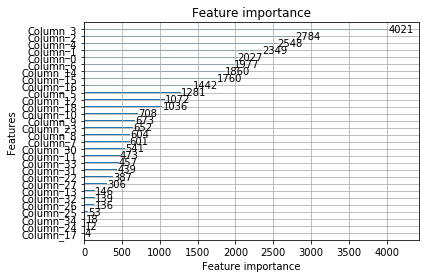

## Fold In 7 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0441646	valid_0's auc: 0.997751
[1000]	valid_0's binary_logloss: 0.0374291	valid_0's auc: 0.997802
[1500]	valid_0's binary_logloss: 0.0369815	valid_0's auc: 0.997814
[2000]	valid_0's binary_logloss: 0.0369622	valid_0's auc: 0.997807
Early stopping, best iteration is:
[1487]	valid_0's binary_logloss: 0.0370009	valid_0's auc: 0.997816


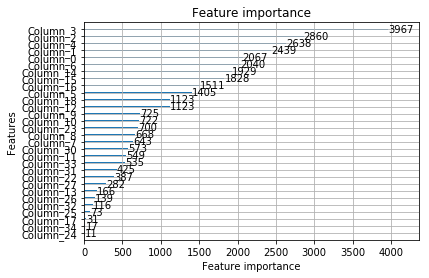

## Fold In 8 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0407833	valid_0's auc: 0.997668
[1000]	valid_0's binary_logloss: 0.0336405	valid_0's auc: 0.997727
[1500]	valid_0's binary_logloss: 0.0331967	valid_0's auc: 0.997712
[2000]	valid_0's binary_logloss: 0.0333136	valid_0's auc: 0.997677
Early stopping, best iteration is:
[1047]	valid_0's binary_logloss: 0.0335396	valid_0's auc: 0.997731


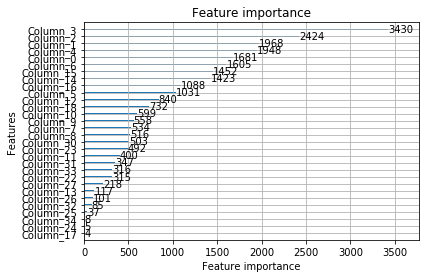

## Fold In 9 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0447185	valid_0's auc: 0.997814
[1000]	valid_0's binary_logloss: 0.0371258	valid_0's auc: 0.9979
[1500]	valid_0's binary_logloss: 0.0362779	valid_0's auc: 0.997924
[2000]	valid_0's binary_logloss: 0.0361162	valid_0's auc: 0.997929
[2500]	valid_0's binary_logloss: 0.036031	valid_0's auc: 0.997934
[3000]	valid_0's binary_logloss: 0.0360859	valid_0's auc: 0.997918
Early stopping, best iteration is:
[2391]	valid_0's binary_logloss: 0.0360253	valid_0's auc: 0.997939


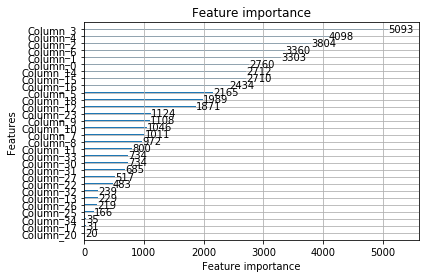

## Fold In 10 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0434477	valid_0's auc: 0.997818
[1000]	valid_0's binary_logloss: 0.0357779	valid_0's auc: 0.997926
[1500]	valid_0's binary_logloss: 0.0349308	valid_0's auc: 0.99796
[2000]	valid_0's binary_logloss: 0.0347101	valid_0's auc: 0.997975
[2500]	valid_0's binary_logloss: 0.0345694	valid_0's auc: 0.997988
[3000]	valid_0's binary_logloss: 0.0345902	valid_0's auc: 0.997988
[3500]	valid_0's binary_logloss: 0.0346578	valid_0's auc: 0.997994
Early stopping, best iteration is:
[2725]	valid_0's binary_logloss: 0.0345312	valid_0's auc: 0.997988


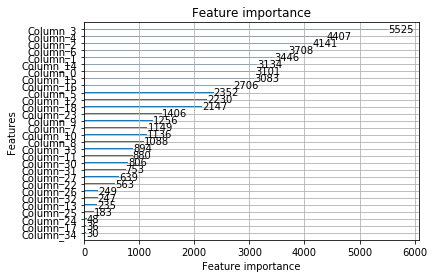

Training LightGBM Done!
Feature name is severe_toxic
## Fold In 1 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0280635	valid_0's auc: 0.990818
[1000]	valid_0's binary_logloss: 0.0247635	valid_0's auc: 0.990772
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.277829	valid_0's auc: 0.991231


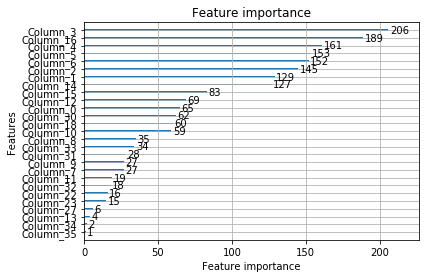

## Fold In 2 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0265558	valid_0's auc: 0.992161
[1000]	valid_0's binary_logloss: 0.0230809	valid_0's auc: 0.992068
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.0426315	valid_0's auc: 0.992228


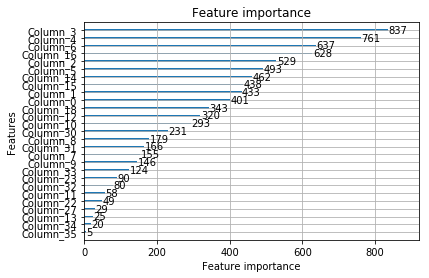

## Fold In 3 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0238009	valid_0's auc: 0.993553
[1000]	valid_0's binary_logloss: 0.0201162	valid_0's auc: 0.993594
[1500]	valid_0's binary_logloss: 0.020072	valid_0's auc: 0.99354
[2000]	valid_0's binary_logloss: 0.020208	valid_0's auc: 0.993411
Early stopping, best iteration is:
[1121]	valid_0's binary_logloss: 0.0200584	valid_0's auc: 0.993626


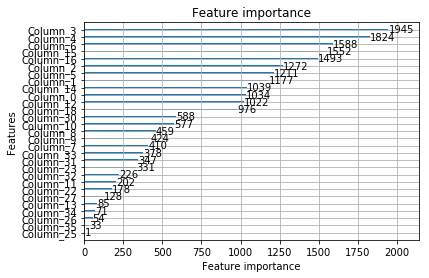

## Fold In 4 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0211186	valid_0's auc: 0.991781
[1000]	valid_0's binary_logloss: 0.0177078	valid_0's auc: 0.992218
[1500]	valid_0's binary_logloss: 0.0178305	valid_0's auc: 0.992072
[2000]	valid_0's binary_logloss: 0.0180181	valid_0's auc: 0.991915
Early stopping, best iteration is:
[1014]	valid_0's binary_logloss: 0.0177003	valid_0's auc: 0.992227


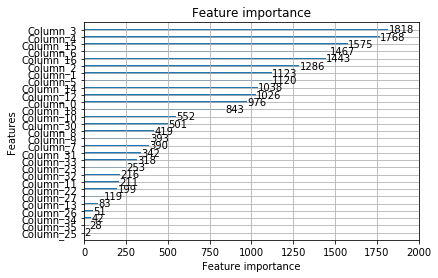

## Fold In 5 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0246566	valid_0's auc: 0.99177
[1000]	valid_0's binary_logloss: 0.0212787	valid_0's auc: 0.991719
Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.0370299	valid_0's auc: 0.99179


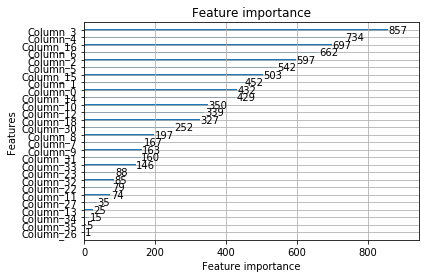

## Fold In 6 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0228389	valid_0's auc: 0.9927
[1000]	valid_0's binary_logloss: 0.0193949	valid_0's auc: 0.992722
Early stopping, best iteration is:
[358]	valid_0's binary_logloss: 0.0332025	valid_0's auc: 0.992771


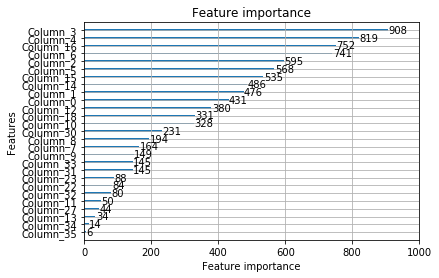

## Fold In 7 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0221647	valid_0's auc: 0.993145
[1000]	valid_0's binary_logloss: 0.0185437	valid_0's auc: 0.993255
[1500]	valid_0's binary_logloss: 0.0185031	valid_0's auc: 0.993276
[2000]	valid_0's binary_logloss: 0.018488	valid_0's auc: 0.993238
Early stopping, best iteration is:
[1231]	valid_0's binary_logloss: 0.0184626	valid_0's auc: 0.99329


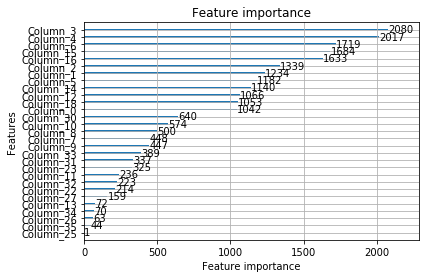

## Fold In 8 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0244889	valid_0's auc: 0.992798
[1000]	valid_0's binary_logloss: 0.0210641	valid_0's auc: 0.992706
Early stopping, best iteration is:
[451]	valid_0's binary_logloss: 0.0265621	valid_0's auc: 0.992822


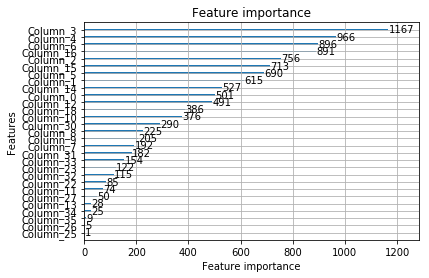

## Fold In 9 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.023293	valid_0's auc: 0.992869
[1000]	valid_0's binary_logloss: 0.0199723	valid_0's auc: 0.992771
[1500]	valid_0's binary_logloss: 0.0200207	valid_0's auc: 0.992741
Early stopping, best iteration is:
[517]	valid_0's binary_logloss: 0.0227914	valid_0's auc: 0.992876


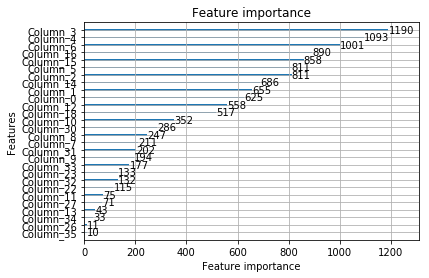

## Fold In 10 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0235319	valid_0's auc: 0.991953
[1000]	valid_0's binary_logloss: 0.020191	valid_0's auc: 0.991975
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.463083	valid_0's auc: 0.992016


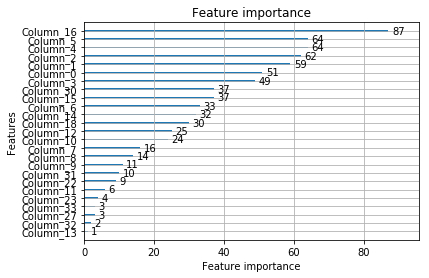

Training LightGBM Done!
Feature name is obscene
## Fold In 1 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0951843	valid_0's auc: 0.980454
[1000]	valid_0's binary_logloss: 0.0865699	valid_0's auc: 0.979928
[1500]	valid_0's binary_logloss: 0.0850008	valid_0's auc: 0.979193
Early stopping, best iteration is:
[508]	valid_0's binary_logloss: 0.0946652	valid_0's auc: 0.980474


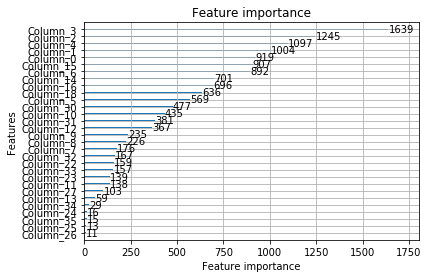

## Fold In 2 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0981006	valid_0's auc: 0.981715
[1000]	valid_0's binary_logloss: 0.0903559	valid_0's auc: 0.981231
[1500]	valid_0's binary_logloss: 0.0892849	valid_0's auc: 0.980456
Early stopping, best iteration is:
[598]	valid_0's binary_logloss: 0.0950064	valid_0's auc: 0.98179


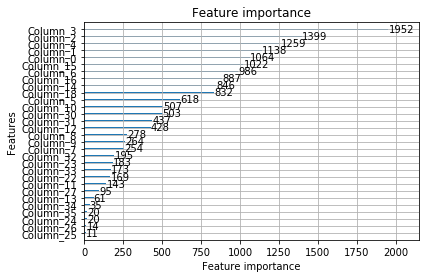

## Fold In 3 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0774191	valid_0's auc: 0.985014
[1000]	valid_0's binary_logloss: 0.0675828	valid_0's auc: 0.985165
[1500]	valid_0's binary_logloss: 0.0662498	valid_0's auc: 0.985092
Early stopping, best iteration is:
[831]	valid_0's binary_logloss: 0.0690505	valid_0's auc: 0.985212


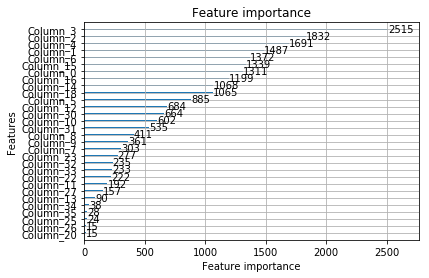

## Fold In 4 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0740235	valid_0's auc: 0.985021
[1000]	valid_0's binary_logloss: 0.0643983	valid_0's auc: 0.985944
[1500]	valid_0's binary_logloss: 0.0631564	valid_0's auc: 0.986052
[2000]	valid_0's binary_logloss: 0.0629992	valid_0's auc: 0.985966
[2500]	valid_0's binary_logloss: 0.0631269	valid_0's auc: 0.985818
Early stopping, best iteration is:
[1596]	valid_0's binary_logloss: 0.0630447	valid_0's auc: 0.986071


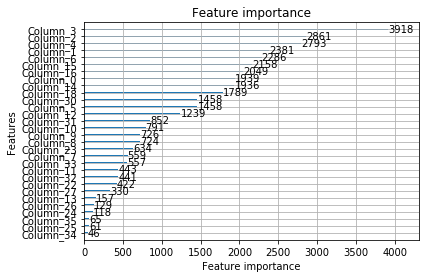

## Fold In 5 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0734555	valid_0's auc: 0.986279
[1000]	valid_0's binary_logloss: 0.062839	valid_0's auc: 0.987513
[1500]	valid_0's binary_logloss: 0.0611653	valid_0's auc: 0.987694
[2000]	valid_0's binary_logloss: 0.0607132	valid_0's auc: 0.987694
[2500]	valid_0's binary_logloss: 0.0605448	valid_0's auc: 0.987707
[3000]	valid_0's binary_logloss: 0.0606339	valid_0's auc: 0.987638
Early stopping, best iteration is:
[2290]	valid_0's binary_logloss: 0.0605406	valid_0's auc: 0.987725


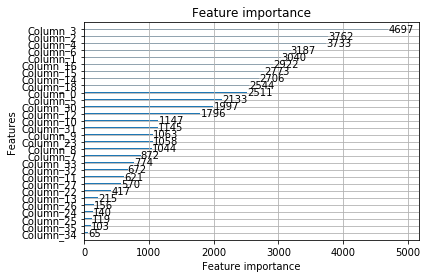

## Fold In 6 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0813503	valid_0's auc: 0.981315
[1000]	valid_0's binary_logloss: 0.0718552	valid_0's auc: 0.982826
[1500]	valid_0's binary_logloss: 0.0701489	valid_0's auc: 0.983277
[2000]	valid_0's binary_logloss: 0.069621	valid_0's auc: 0.983433
[2500]	valid_0's binary_logloss: 0.0695527	valid_0's auc: 0.983483
[3000]	valid_0's binary_logloss: 0.0695561	valid_0's auc: 0.983478
Early stopping, best iteration is:
[2331]	valid_0's binary_logloss: 0.0695043	valid_0's auc: 0.983489


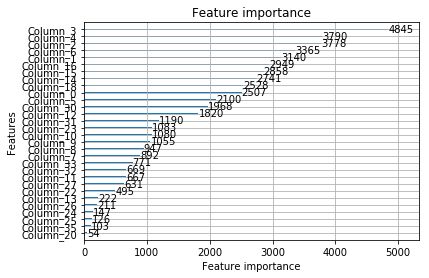

## Fold In 7 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0748915	valid_0's auc: 0.983464
[1000]	valid_0's binary_logloss: 0.0657397	valid_0's auc: 0.985025
[1500]	valid_0's binary_logloss: 0.0645082	valid_0's auc: 0.98548
[2000]	valid_0's binary_logloss: 0.0643766	valid_0's auc: 0.985577
[2500]	valid_0's binary_logloss: 0.0645337	valid_0's auc: 0.98559
Early stopping, best iteration is:
[1852]	valid_0's binary_logloss: 0.0643315	valid_0's auc: 0.985573


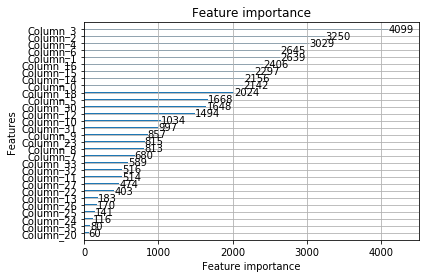

## Fold In 8 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0753454	valid_0's auc: 0.986843
[1000]	valid_0's binary_logloss: 0.066284	valid_0's auc: 0.988429
[1500]	valid_0's binary_logloss: 0.0646343	valid_0's auc: 0.988907
[2000]	valid_0's binary_logloss: 0.0640768	valid_0's auc: 0.989082
[2500]	valid_0's binary_logloss: 0.0640137	valid_0's auc: 0.989136
[3000]	valid_0's binary_logloss: 0.064131	valid_0's auc: 0.98911
Early stopping, best iteration is:
[2421]	valid_0's binary_logloss: 0.0639713	valid_0's auc: 0.989139


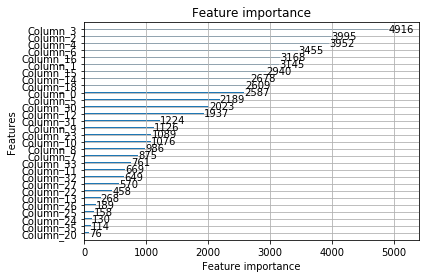

## Fold In 9 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0702939	valid_0's auc: 0.986576
[1000]	valid_0's binary_logloss: 0.0611554	valid_0's auc: 0.988053
[1500]	valid_0's binary_logloss: 0.0599628	valid_0's auc: 0.988354
[2000]	valid_0's binary_logloss: 0.0596519	valid_0's auc: 0.988438
[2500]	valid_0's binary_logloss: 0.0596481	valid_0's auc: 0.988456
[3000]	valid_0's binary_logloss: 0.0598482	valid_0's auc: 0.988401
Early stopping, best iteration is:
[2489]	valid_0's binary_logloss: 0.0596332	valid_0's auc: 0.988458


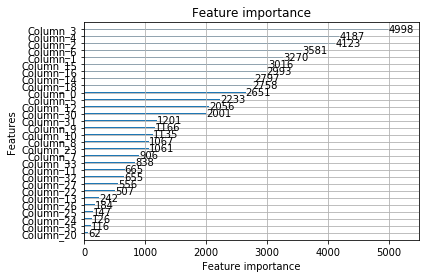

## Fold In 10 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0741567	valid_0's auc: 0.986484
[1000]	valid_0's binary_logloss: 0.0641081	valid_0's auc: 0.98796
[1500]	valid_0's binary_logloss: 0.0627424	valid_0's auc: 0.98835
[2000]	valid_0's binary_logloss: 0.0625162	valid_0's auc: 0.988432
[2500]	valid_0's binary_logloss: 0.0626081	valid_0's auc: 0.988403
Early stopping, best iteration is:
[1854]	valid_0's binary_logloss: 0.0624605	valid_0's auc: 0.988443


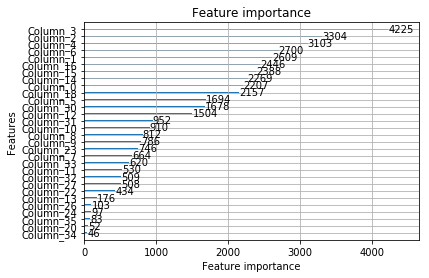

Training LightGBM Done!
Feature name is threat
## Fold In 1 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0194137	valid_0's auc: 0.947366
[1000]	valid_0's binary_logloss: 0.0168804	valid_0's auc: 0.942706
Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.0370318	valid_0's auc: 0.950184


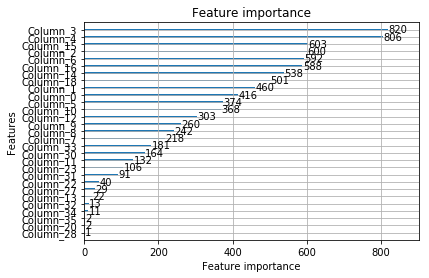

## Fold In 2 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0169063	valid_0's auc: 0.962238
[1000]	valid_0's binary_logloss: 0.0136075	valid_0's auc: 0.962069
[1500]	valid_0's binary_logloss: 0.0136112	valid_0's auc: 0.961048
Early stopping, best iteration is:
[640]	valid_0's binary_logloss: 0.0144908	valid_0's auc: 0.963756


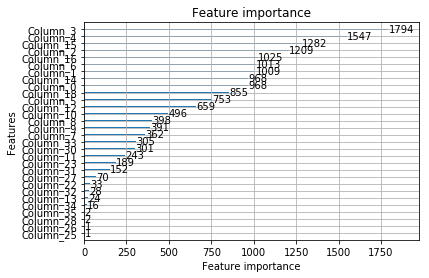

## Fold In 3 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0178585	valid_0's auc: 0.979204
[1000]	valid_0's binary_logloss: 0.0141572	valid_0's auc: 0.979478
[1500]	valid_0's binary_logloss: 0.0140432	valid_0's auc: 0.978562
Early stopping, best iteration is:
[883]	valid_0's binary_logloss: 0.0143023	valid_0's auc: 0.97962


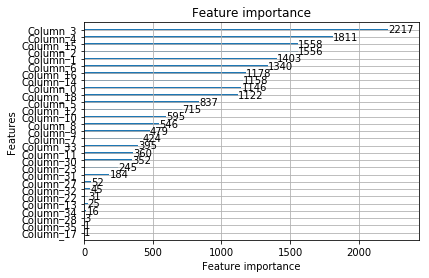

## Fold In 4 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0178129	valid_0's auc: 0.968366
[1000]	valid_0's binary_logloss: 0.0144781	valid_0's auc: 0.97019
[1500]	valid_0's binary_logloss: 0.0144972	valid_0's auc: 0.970406
[2000]	valid_0's binary_logloss: 0.014584	valid_0's auc: 0.970535
Early stopping, best iteration is:
[1302]	valid_0's binary_logloss: 0.0144392	valid_0's auc: 0.970575


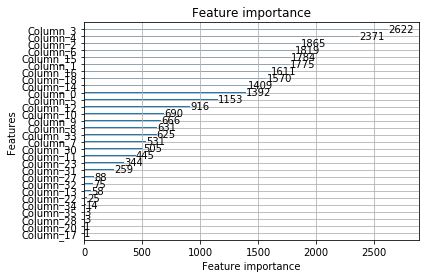

## Fold In 5 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.014779	valid_0's auc: 0.973335
[1000]	valid_0's binary_logloss: 0.0112229	valid_0's auc: 0.975293
[1500]	valid_0's binary_logloss: 0.0111431	valid_0's auc: 0.975435
[2000]	valid_0's binary_logloss: 0.0112225	valid_0's auc: 0.975131
Early stopping, best iteration is:
[1333]	valid_0's binary_logloss: 0.0111046	valid_0's auc: 0.97584


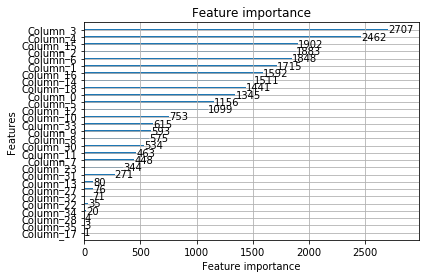

## Fold In 6 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0149069	valid_0's auc: 0.973744
[1000]	valid_0's binary_logloss: 0.0111874	valid_0's auc: 0.978101
[1500]	valid_0's binary_logloss: 0.0109936	valid_0's auc: 0.978997
[2000]	valid_0's binary_logloss: 0.0108489	valid_0's auc: 0.979534
[2500]	valid_0's binary_logloss: 0.0108596	valid_0's auc: 0.979197
Early stopping, best iteration is:
[1761]	valid_0's binary_logloss: 0.0108629	valid_0's auc: 0.979698


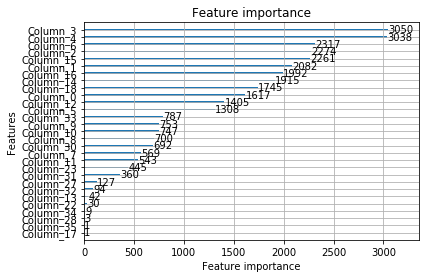

## Fold In 7 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0136042	valid_0's auc: 0.970342
[1000]	valid_0's binary_logloss: 0.0100728	valid_0's auc: 0.974306
[1500]	valid_0's binary_logloss: 0.00992491	valid_0's auc: 0.97562
[2000]	valid_0's binary_logloss: 0.00989612	valid_0's auc: 0.976251
[2500]	valid_0's binary_logloss: 0.00990001	valid_0's auc: 0.977007
[3000]	valid_0's binary_logloss: 0.00996995	valid_0's auc: 0.977054
Early stopping, best iteration is:
[2143]	valid_0's binary_logloss: 0.0098779	valid_0's auc: 0.976491


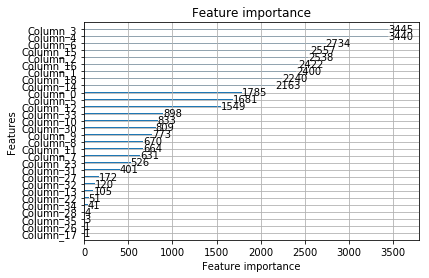

## Fold In 8 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0153194	valid_0's auc: 0.971547
[1000]	valid_0's binary_logloss: 0.0117582	valid_0's auc: 0.975182
[1500]	valid_0's binary_logloss: 0.0115553	valid_0's auc: 0.976583
[2000]	valid_0's binary_logloss: 0.0115583	valid_0's auc: 0.976633
[2500]	valid_0's binary_logloss: 0.0116148	valid_0's auc: 0.976422
Early stopping, best iteration is:
[1550]	valid_0's binary_logloss: 0.0115391	valid_0's auc: 0.976673


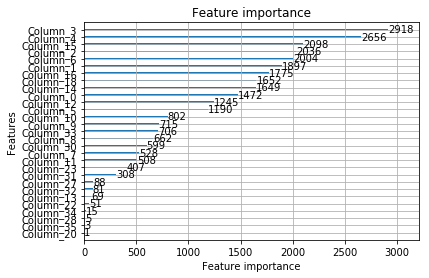

## Fold In 9 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0148536	valid_0's auc: 0.971268
[1000]	valid_0's binary_logloss: 0.0112619	valid_0's auc: 0.974774
[1500]	valid_0's binary_logloss: 0.0110966	valid_0's auc: 0.975738
[2000]	valid_0's binary_logloss: 0.0111253	valid_0's auc: 0.9757
[2500]	valid_0's binary_logloss: 0.0111838	valid_0's auc: 0.975695
Early stopping, best iteration is:
[1531]	valid_0's binary_logloss: 0.0110748	valid_0's auc: 0.975879


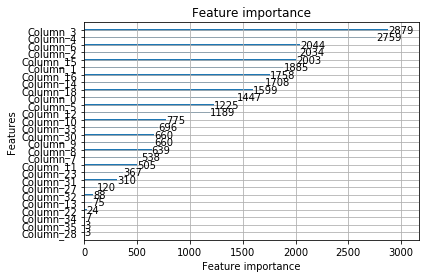

## Fold In 10 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.016906	valid_0's auc: 0.963143
[1000]	valid_0's binary_logloss: 0.0138465	valid_0's auc: 0.96759
[1500]	valid_0's binary_logloss: 0.0138923	valid_0's auc: 0.968609
[2000]	valid_0's binary_logloss: 0.0140926	valid_0's auc: 0.967994
Early stopping, best iteration is:
[1093]	valid_0's binary_logloss: 0.0138108	valid_0's auc: 0.9681


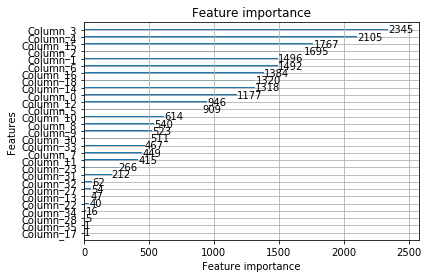

Training LightGBM Done!
Feature name is insult
## Fold In 1 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0922407	valid_0's auc: 0.979597
[1000]	valid_0's binary_logloss: 0.0891486	valid_0's auc: 0.979555
[1500]	valid_0's binary_logloss: 0.0886907	valid_0's auc: 0.979354
Early stopping, best iteration is:
[731]	valid_0's binary_logloss: 0.0896984	valid_0's auc: 0.979665


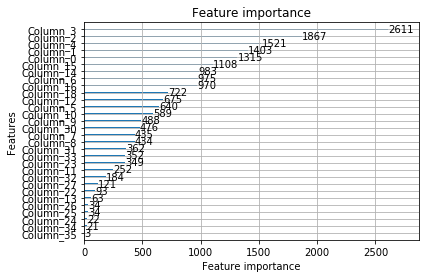

## Fold In 2 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0722309	valid_0's auc: 0.986315
[1000]	valid_0's binary_logloss: 0.0673258	valid_0's auc: 0.986175
[1500]	valid_0's binary_logloss: 0.067322	valid_0's auc: 0.985946
Early stopping, best iteration is:
[695]	valid_0's binary_logloss: 0.0683169	valid_0's auc: 0.98635


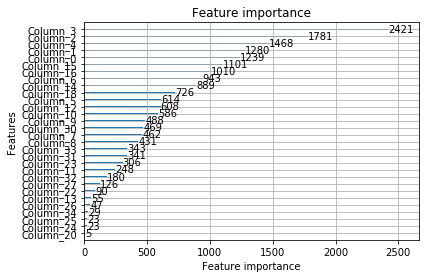

## Fold In 3 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0697448	valid_0's auc: 0.985445
[1000]	valid_0's binary_logloss: 0.0635878	valid_0's auc: 0.986049
[1500]	valid_0's binary_logloss: 0.0628069	valid_0's auc: 0.986272
[2000]	valid_0's binary_logloss: 0.0627637	valid_0's auc: 0.986239
[2500]	valid_0's binary_logloss: 0.0628194	valid_0's auc: 0.986172
Early stopping, best iteration is:
[1655]	valid_0's binary_logloss: 0.0627245	valid_0's auc: 0.986289


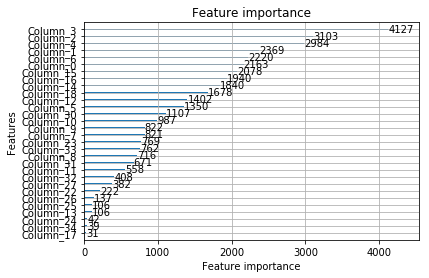

## Fold In 4 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0621136	valid_0's auc: 0.98916
[1000]	valid_0's binary_logloss: 0.0554982	valid_0's auc: 0.989714
[1500]	valid_0's binary_logloss: 0.0548517	valid_0's auc: 0.989848
[2000]	valid_0's binary_logloss: 0.0547443	valid_0's auc: 0.989891
[2500]	valid_0's binary_logloss: 0.0548295	valid_0's auc: 0.989872
[3000]	valid_0's binary_logloss: 0.0548525	valid_0's auc: 0.989872
Early stopping, best iteration is:
[2116]	valid_0's binary_logloss: 0.054724	valid_0's auc: 0.989898


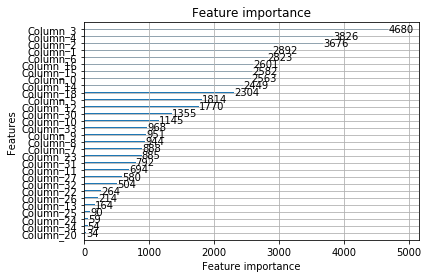

## Fold In 5 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0647752	valid_0's auc: 0.988579
[1000]	valid_0's binary_logloss: 0.0585686	valid_0's auc: 0.988886
[1500]	valid_0's binary_logloss: 0.058074	valid_0's auc: 0.988904
[2000]	valid_0's binary_logloss: 0.0580914	valid_0's auc: 0.988854
Early stopping, best iteration is:
[1403]	valid_0's binary_logloss: 0.0580784	valid_0's auc: 0.988923


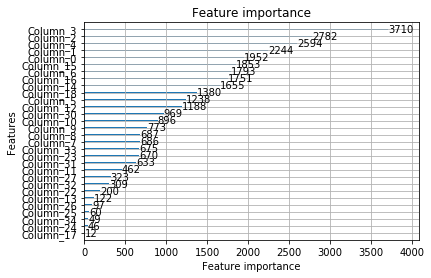

## Fold In 6 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0615272	valid_0's auc: 0.989509
[1000]	valid_0's binary_logloss: 0.0547324	valid_0's auc: 0.990207
[1500]	valid_0's binary_logloss: 0.0540205	valid_0's auc: 0.990382
[2000]	valid_0's binary_logloss: 0.0538167	valid_0's auc: 0.990448
[2500]	valid_0's binary_logloss: 0.0537777	valid_0's auc: 0.990452
[3000]	valid_0's binary_logloss: 0.0538861	valid_0's auc: 0.990407
[3500]	valid_0's binary_logloss: 0.0539762	valid_0's auc: 0.990391
Early stopping, best iteration is:
[2521]	valid_0's binary_logloss: 0.05376	valid_0's auc: 0.990462


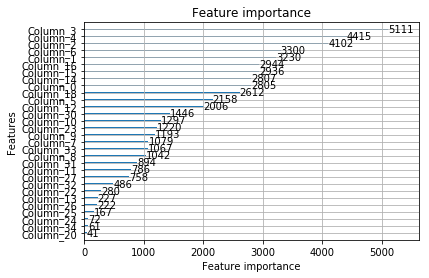

## Fold In 7 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0615961	valid_0's auc: 0.990237
[1000]	valid_0's binary_logloss: 0.0555836	valid_0's auc: 0.990962
[1500]	valid_0's binary_logloss: 0.0554233	valid_0's auc: 0.991103
[2000]	valid_0's binary_logloss: 0.0555698	valid_0's auc: 0.991135
Early stopping, best iteration is:
[1315]	valid_0's binary_logloss: 0.0553683	valid_0's auc: 0.991083


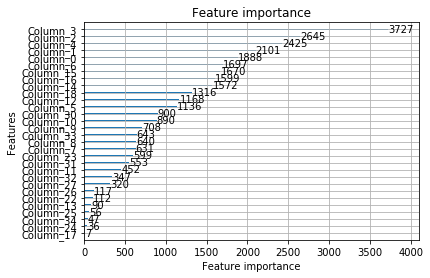

## Fold In 8 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0615449	valid_0's auc: 0.990227
[1000]	valid_0's binary_logloss: 0.055793	valid_0's auc: 0.990927
[1500]	valid_0's binary_logloss: 0.0555439	valid_0's auc: 0.991083
[2000]	valid_0's binary_logloss: 0.0556807	valid_0's auc: 0.991107
[2500]	valid_0's binary_logloss: 0.055827	valid_0's auc: 0.991087
Early stopping, best iteration is:
[1587]	valid_0's binary_logloss: 0.0554929	valid_0's auc: 0.991095


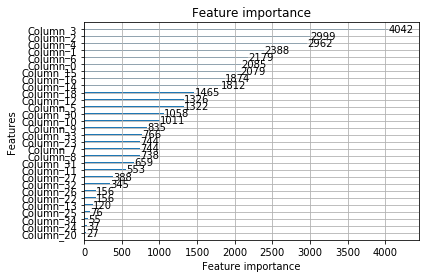

## Fold In 9 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0625462	valid_0's auc: 0.988367
[1000]	valid_0's binary_logloss: 0.0552865	valid_0's auc: 0.989647
[1500]	valid_0's binary_logloss: 0.0541874	valid_0's auc: 0.99009
[2000]	valid_0's binary_logloss: 0.054	valid_0's auc: 0.990175
[2500]	valid_0's binary_logloss: 0.0540076	valid_0's auc: 0.990187
[3000]	valid_0's binary_logloss: 0.0541474	valid_0's auc: 0.990164
Early stopping, best iteration is:
[2228]	valid_0's binary_logloss: 0.0539703	valid_0's auc: 0.990204


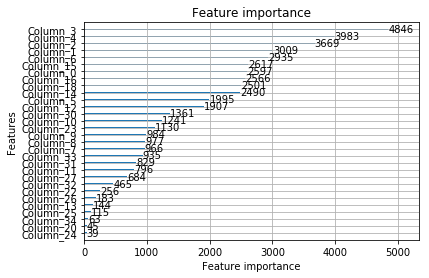

## Fold In 10 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0640951	valid_0's auc: 0.989211
[1000]	valid_0's binary_logloss: 0.056287	valid_0's auc: 0.990314
[1500]	valid_0's binary_logloss: 0.055163	valid_0's auc: 0.99064
[2000]	valid_0's binary_logloss: 0.0547575	valid_0's auc: 0.990757
[2500]	valid_0's binary_logloss: 0.0545989	valid_0's auc: 0.990797
[3000]	valid_0's binary_logloss: 0.0545264	valid_0's auc: 0.990825
[3500]	valid_0's binary_logloss: 0.05449	valid_0's auc: 0.990857
[4000]	valid_0's binary_logloss: 0.0546272	valid_0's auc: 0.990827
Early stopping, best iteration is:
[3420]	valid_0's binary_logloss: 0.0544505	valid_0's auc: 0.990867


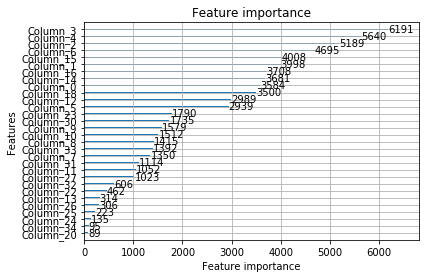

Training LightGBM Done!
Feature name is identity_hate
## Fold In 1 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0329047	valid_0's auc: 0.961671
[1000]	valid_0's binary_logloss: 0.0285269	valid_0's auc: 0.966492
[1500]	valid_0's binary_logloss: 0.0286605	valid_0's auc: 0.966578
[2000]	valid_0's binary_logloss: 0.0288052	valid_0's auc: 0.966128
Early stopping, best iteration is:
[1125]	valid_0's binary_logloss: 0.028478	valid_0's auc: 0.966907


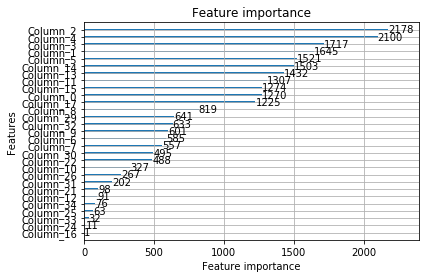

## Fold In 2 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0342939	valid_0's auc: 0.972298
[1000]	valid_0's binary_logloss: 0.0291634	valid_0's auc: 0.97379
[1500]	valid_0's binary_logloss: 0.0287825	valid_0's auc: 0.974385
[2000]	valid_0's binary_logloss: 0.0288591	valid_0's auc: 0.974213
[2500]	valid_0's binary_logloss: 0.0290252	valid_0's auc: 0.973708
Early stopping, best iteration is:
[1547]	valid_0's binary_logloss: 0.0287634	valid_0's auc: 0.974411


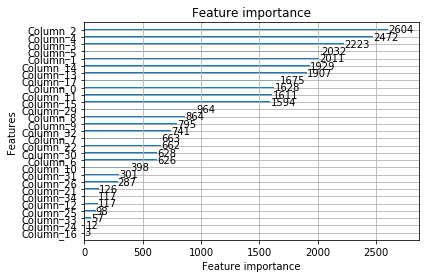

## Fold In 3 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0337996	valid_0's auc: 0.970956
[1000]	valid_0's binary_logloss: 0.0286343	valid_0's auc: 0.973007
[1500]	valid_0's binary_logloss: 0.0281477	valid_0's auc: 0.974054
[2000]	valid_0's binary_logloss: 0.0281007	valid_0's auc: 0.974341
[2500]	valid_0's binary_logloss: 0.0282209	valid_0's auc: 0.974143
Early stopping, best iteration is:
[1933]	valid_0's binary_logloss: 0.0280855	valid_0's auc: 0.974321


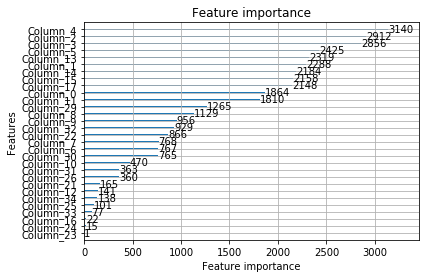

## Fold In 4 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0314683	valid_0's auc: 0.970423
[1000]	valid_0's binary_logloss: 0.0265462	valid_0's auc: 0.974259
[1500]	valid_0's binary_logloss: 0.0262697	valid_0's auc: 0.974344
[2000]	valid_0's binary_logloss: 0.0264048	valid_0's auc: 0.973827
Early stopping, best iteration is:
[1420]	valid_0's binary_logloss: 0.0262533	valid_0's auc: 0.97445


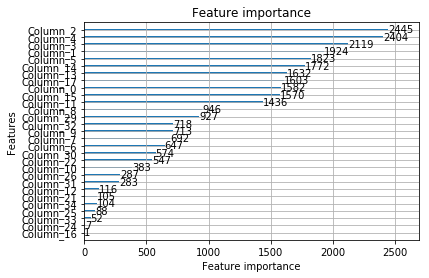

## Fold In 5 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0305158	valid_0's auc: 0.975589
[1000]	valid_0's binary_logloss: 0.0254909	valid_0's auc: 0.977082
[1500]	valid_0's binary_logloss: 0.0250641	valid_0's auc: 0.977301
[2000]	valid_0's binary_logloss: 0.0250425	valid_0's auc: 0.976957
Early stopping, best iteration is:
[1419]	valid_0's binary_logloss: 0.0250856	valid_0's auc: 0.977381


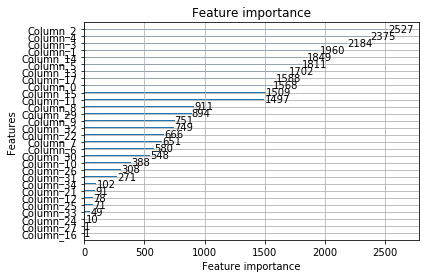

## Fold In 6 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0307841	valid_0's auc: 0.969602
[1000]	valid_0's binary_logloss: 0.0259884	valid_0's auc: 0.97173
[1500]	valid_0's binary_logloss: 0.0255655	valid_0's auc: 0.972261
[2000]	valid_0's binary_logloss: 0.025527	valid_0's auc: 0.972302
[2500]	valid_0's binary_logloss: 0.0255887	valid_0's auc: 0.971986
[3000]	valid_0's binary_logloss: 0.0256351	valid_0's auc: 0.971879
Early stopping, best iteration is:
[2065]	valid_0's binary_logloss: 0.0255155	valid_0's auc: 0.972376


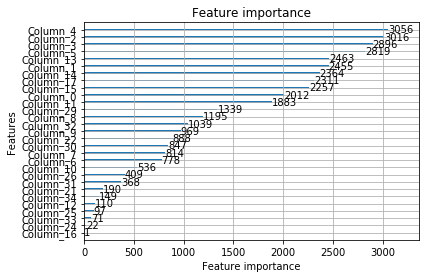

## Fold In 7 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0341995	valid_0's auc: 0.966106
[1000]	valid_0's binary_logloss: 0.0294754	valid_0's auc: 0.96847
[1500]	valid_0's binary_logloss: 0.029264	valid_0's auc: 0.968547
[2000]	valid_0's binary_logloss: 0.0293348	valid_0's auc: 0.968591
Early stopping, best iteration is:
[1444]	valid_0's binary_logloss: 0.0292356	valid_0's auc: 0.968596


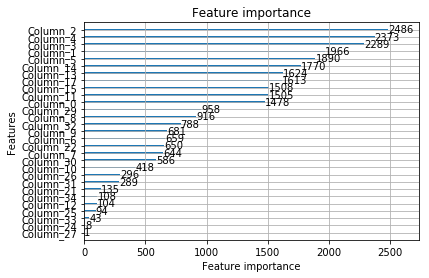

## Fold In 8 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0341762	valid_0's auc: 0.967976
[1000]	valid_0's binary_logloss: 0.0295849	valid_0's auc: 0.969131
[1500]	valid_0's binary_logloss: 0.0294068	valid_0's auc: 0.969184
[2000]	valid_0's binary_logloss: 0.0295685	valid_0's auc: 0.968835
Early stopping, best iteration is:
[1370]	valid_0's binary_logloss: 0.0293544	valid_0's auc: 0.96935


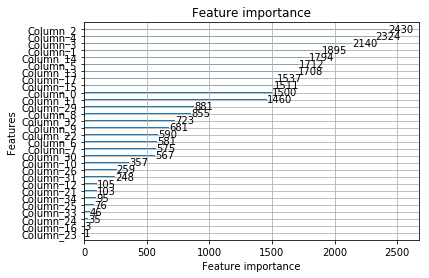

## Fold In 9 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.035748	valid_0's auc: 0.972336
[1000]	valid_0's binary_logloss: 0.0305602	valid_0's auc: 0.973367
[1500]	valid_0's binary_logloss: 0.0303089	valid_0's auc: 0.973293
[2000]	valid_0's binary_logloss: 0.0304005	valid_0's auc: 0.972874
Early stopping, best iteration is:
[1099]	valid_0's binary_logloss: 0.0304183	valid_0's auc: 0.973479


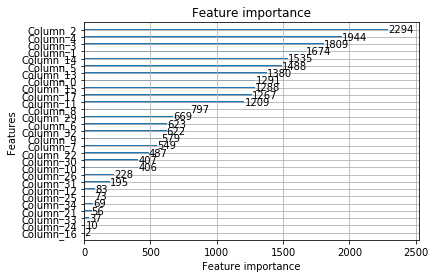

## Fold In 10 ##
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's binary_logloss: 0.0338502	valid_0's auc: 0.969387
[1000]	valid_0's binary_logloss: 0.029221	valid_0's auc: 0.970366
[1500]	valid_0's binary_logloss: 0.0290501	valid_0's auc: 0.970384
[2000]	valid_0's binary_logloss: 0.0290691	valid_0's auc: 0.970392
Early stopping, best iteration is:
[1227]	valid_0's binary_logloss: 0.0290498	valid_0's auc: 0.970547


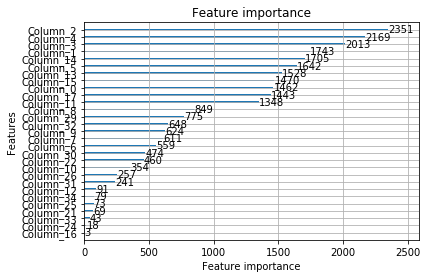

Training LightGBM Done!
Overall AUC Score is 0.9843193453511564
For each:


In [48]:
predictions, auc_scores = [], []
for i, feature_name in enumerate(list_classes):
    prediction, auc = fit_every_feature_model(train_ensembled_data[i], train_df[feature_name].values, feature_name, test_ensembled_data[i], 10, predict=True)
    auc_scores.append(auc)
    predictions.append(prediction)
print('Overall AUC Score is {}'.format(sum(auc_scores) / 6))
print('For each:'.format(auc_scores))

In [49]:
submission = pd.read_csv('datasets/sample_submission.csv')
for i, feature_name in enumerate(list_classes):
    submission[feature_name] = predictions[i]
submission.to_csv('results/LightGBM/LightGBM_with_Meta_data.csv', index=False)

## Training Styles

In [ ]:
STAMP = 'model_pool/av_pos_cnn/pavel_cnn_%.2f_%.2f'%(0.5, 0.5)

## Keras Based

In [ ]:
def _train_model_by_auc(model, batch_size, train_x, train_y, val_x, val_y):
    best_auc = -1
    best_weight = None
    best_epoch = 0
    current_epoch = 1
    
    while True:
        model.fit(train_x, train_y, batch_size=batch_size, epoch=1, validation_data=[val_x, val_y])
        y_pred = model.predict(val_x, batch_size=batch_size)
        current_auc = roc_auc_score(val_y, y_pred)
        print('Epoch {} auc {:.6f} best_auc {:.6f}'.format(current_epoch, current_auc, best_auc))
        current_epoch += 1
        if best_auc < current_auc or best_auc == -1:
            best_auc = current_auc
            best_weight = model.get_weights()
            best_epoch = current_epoch
        else:
            # early stop
            if current_epoch - best_epoch == 5:
                break
                
    model.set_weights(best_weights)
    return model, best_auc

def _train_model_by_logloss(model, batch_size, train_x, pos_train_x, train_y, val_x, pos_val_x, val_y, fold_id):
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)
    best_model_path = STAMP + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
    train_data = {'Onehot': train_x, 'POS': pos_train_x}
    val_data = {'Onehot': val_x, 'POS': pos_val_x}
    
    hist = model.fit(train_data, train_y, validation_data=(val_data, val_y), epochs=50, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint])
    best_val_score = min(hist.history['val_loss'])
    predictions = model.predict(val_data)
    auc = roc_auc_score(val_y, predictions)
    print('AUC Score', auc)
    return model, best_val_score, auc, predictions

def train_folds(x, pos_x, y, fold_count, batch_size, get_model_func):
    fold_size = len(x) // fold_count
    models = []
    fold_predictions = []
    score, total_auc = 0, 0
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        
        if fold_id == fold_count - 1:
            fold_end = len(x)
            
        train_x = np.concatenate((x[:fold_start], x[fold_end:]))
        train_y = np.concatenate((y[:fold_start], y[fold_end:]))
        
        val_x = x[fold_start: fold_end]
        val_y = y[fold_start: fold_end]
        
        pos_train_x = np.concatenate((pos_x[:fold_start], pos_x[fold_end:]))
        pos_val_x = pos_x[fold_start: fold_end]
        print('## In fold {} ## : '.format(fold_id + 1))
        model, best_val_score, auc, fold_prediction = _train_model_by_logloss(get_model_func, batch_size, train_x, pos_train_x, train_y, val_x, pos_val_x, val_y, fold_id)
        
        score += best_val_score
        total_auc += auc
        fold_predictions.append(fold_prediction)
        models.append(model)
    return models, score / fold_count, total_auc / fold_count , fold_predictions

## Model Zoo

## Keras Based

In [ ]:
class AttentionWeightedAverage(Layer):
    """
    Model for computing a weighted average of the different channels across timesteps.
    Uses 1 parameter per channel to compute the attention value for a single timestep.
    """
    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)
        
    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))
        
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        attn_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(attn_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, attn_weights]
        return result
    
    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)
    
    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)
    
    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [ ]:
class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    With TensorFlow Backend.
    """
    def __init__(self, k=1, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2] * self.k)
    
    def call(self, inputs):
        # top_k function can only be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1])
        top_k = tf.nn.top_k(shifted_input, self.k, True, None)[0]
        return Flatten()(top_k)

In [ ]:
def get_av_cnn(nb_words, embedding_dim, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Embedding(nb_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=False)
    
    filter_nums = 300
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    embedding_sequences = embedding_layer(input_layer)
    final_embedding_sequences = SpatialDropout1D(0.25)(embedding_sequences)
    
    conv_0 = Conv1D(filter_nums, 1, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_1 = Conv1D(filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_2 = Conv1D(filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_3 = Conv1D(filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    
    attn_0 = AttentionWeightedAverage()(conv_0)
    avg_0 = GlobalAveragePooling1D()(conv_0)
    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    
    attn_1 = AttentionWeightedAverage()(conv_1)
    avg_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    
    attn_2 = AttentionWeightedAverage()(conv_2)
    avg_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    
    attn_3 = AttentionWeightedAverage()(conv_3)
    avg_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_3 = GlobalMaxPooling1D()(conv_3)
    
    merged_maxpool = merge([maxpool_0, maxpool_1, maxpool_2, maxpool_3], mode='concat', concat_axis=1)
    merged_attn = merge([attn_0, attn_1, attn_2, attn_3], mode='concat', concat_axis=1)
    merged_avg = merge([avg_0, avg_1, avg_2, avg_3], mode='concat', concat_axis=1)
    merged_tensor = merge([merged_maxpool, merged_attn, merged_avg], mode='concat', concat_axis=1)
    
    output = Dropout(0.7)(merged_tensor)
    output = Dense(units=144, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    return model

In [ ]:
def get_av_pos_cnn(nb_words, embedding_dim, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Embedding(nb_words, 
                                embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=max_sequence_length, 
                                trainable=False)
    
    pos_embedding_layer = Embedding(50,
                                    30,
                                    input_length=max_sequence_length,
                                    trainable=True)
    
    filter_nums = 325
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    pos_input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='POS')
    
    embedding_sequences = embedding_layer(input_layer)
    pos_sequences = pos_embedding_layer(pos_input_layer)
    merged_embedding_layer = concatenate([embedding_sequences, pos_sequences])
    final_embedding_sequences = SpatialDropout1D(0.25)(merged_embedding_layer)
    
    conv_0 = Conv1D(filter_nums, 1, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_1 = Conv1D(filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_2 = Conv1D(filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_3 = Conv1D(filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)

    attn_0 = AttentionWeightedAverage()(conv_0)
    avg_0 = GlobalAveragePooling1D()(conv_0)
    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    
    attn_1 = AttentionWeightedAverage()(conv_1)
    avg_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    
    attn_2 = AttentionWeightedAverage()(conv_2)
    avg_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    
    attn_3 = AttentionWeightedAverage()(conv_3)
    avg_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_3 = GlobalMaxPooling1D()(conv_3)
    
    merged_tensor_maxpool = merge([maxpool_0, maxpool_1, maxpool_2, maxpool_3], mode='concat', concat_axis=1)
    merged_tensor_attn = merge([attn_0, attn_1, attn_2, attn_3], mode='concat', concat_axis=1)
    merged_tensor_avg = merge([avg_0, avg_1, avg_2, avg_3], mode='concat', concat_axis=1)
    merged_tensor = merge([merged_tensor_maxpool, merged_tensor_attn, merged_tensor_avg], mode='concat', concat_axis=1)
    
    output = Dropout(0.7)(merged_tensor)
    output = Dense(units=144, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=[input_layer, pos_input_layer], outputs=output)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6, clipvalue=5)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    return model

In [ ]:
def get_kmax_text_cnn(nb_words, embedding_dim, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Embedding(nb_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=False)
    
    filter_nums = 180
    
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    embedding_sequences = embedding_layer(input_layer)
    final_embedding_sequences = SpatialDropout1D(embedding_sequences)
    
    conv_0 = Conv1D(filter_nums, 1, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_1 = Conv1D(filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_2 = Conv1D(filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    conv_3 = Conv1D(filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(final_embedding_sequences)
    
    maxpool_0 = KMaxPooling(k=3)(conv_0)
    maxpool_1 = KMaxPooling(k=3)(conv_1)
    maxpool_2 = KMaxPooling(k=3)(conv_2)
    maxpool_3 = KMaxPooling(k=3)(conv_3)
    
    merged_tensor = merge([maxpool_0, maxpool_1, maxpool_2, maxpool_3], mode='concat', concat_axis=1)
    output = Dropout(0.6)(merged_tensor)
    output = Dense(units=144, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    return model

In [ ]:
def get_rcnn(nb_words, embedding_dim, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Embedding(nb_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=False)
    
    recurrent_units = 64
    filter_nums = 128
    
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    embedding_sequences = embedding_layer(input_layer)
    final_embedding_sequences = SpatialDropout1D(0.2)(embedding_sequences)
    
    rnn_layer = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(final_embedding_sequences)
    conv_layer = Conv1D(filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu', strides=1)(rnn_layer)
    
    maxpool = GlobalMaxPooling1D()(conv_layer)
    attn = AttentionWeightedAverage()(conv_layer)
    avg = GlobalAveragePooling1D()(conv_layer)
    
    merged_tensor = merge([maxpool, attn, avg], mode='concat', concat_axis=1)
    output = Dropout(0.5)(merged_tensor)
    output = Dense(units=120, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6, clipvalue=5)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    return model

In [ ]:
def get_av_rnn(nb_words, embedding_dim, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Embedding(nb_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=False)
    
    recurrent_units = 64
    
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    embedding_sequences = embedding_layer(input_layer)
    final_embedding_sequences = SpatialDropout1D(0.25)(embedding_sequences)
    
    rnn_layer_0 = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(final_embedding_sequences)
    rnn_layer_1 = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(rnn_layer_0)
    merged_rnn_layer = merge([rnn_layer_0, rnn_layer_1], mode='concat', concat_axis=2)
    
    last_layer = Lambda(lambda t: t[:, -1], name='last_layer')(merged_rnn_layer)
    maxpool = GlobalMaxPooling1D()(merged_rnn_layer)
    attn = AttentionWeightedAverage()(merged_rnn_layer)
    avg = GlobalAveragePooling1D()(merged_rnn_layer)
    
    merged_tensor = merge([last_layer, maxpool, attn, avg], mode='concat', concat_axis=1)
    output = Dropout(0.5)(merged_tensor)
    output = Dense(units=144, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6, clipvalue=5)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    return model

In [ ]:
def get_av_pos_rnn(nb_words, embedding_dim, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Embedding(nb_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=False)
    
    pos_embedding_layer = Embedding(50,
                                    35,
                                    input_length=max_sequence_length,
                                    trainable=True)
    
    recurrent_units = 64
    
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    pos_input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='POS')
    embedding_sequences = embedding_layer(input_layer)
    pos_sequences = pos_embedding_layer(pos_input_layer)
    merged_embedding_layer = concatenate([embedding_sequences, pos_sequences], axis=2)
    final_embedding_sequences = SpatialDropout1D(0.2)(merged_embedding_layer)
    
    rnn_layer_0 = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(final_embedding_sequences)
    rnn_layer_0 = SpatialDropout1D(0.3)(rnn_layer_0)
    rnn_layer_1 = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(rnn_layer_0)
    
    last_layer = Lambda(lambda t: t[:, -1], name='last_layer')(rnn_layer_1)
    maxpool = GlobalMaxPooling1D()(rnn_layer_1)
    attn = AttentionWeightedAverage()(rnn_layer_1)
    avg = GlobalAveragePooling1D()(rnn_layer_1)
    
    merged_tensor = merge([last_layer, maxpool, attn, avg], mode='concat', concat_axis=1)
    output = Dropout(0.5)(merged_tensor)
    output = Dense(units=144, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=[input_layer, pos_input_layer], outputs=output)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6, clipvalue=5)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    return model

In [ ]:
def get_dropout_bigru(nb_words, embedding_dims, embedding_matrix, max_sequence_length, out_size):
    embedding_layer = Emebdding(nb_words,
                                embedding_dims,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=False)
    
    recurrent_units = 64
    
    input_layer = Input(shape=(max_sequence_length,), dtype='int32', name='Onehot')
    embedding_sequences = embedding_layer(input_layer)
    final_embedding_sequences = SpatialDropout1D(0.2)(embedding_sequences)
    
    rnn_layer = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(final_embedding_sequences)
    rnn_layer = Dropout(0.35)(rnn_layer)
    rnn_layer = Bidirectional(CuDNNGRU(recurrent_units, return_sequences=True))(rnn_layer)
    
    last_layer = Lambda(lambda t: t[:, -1])(rnn_layer)
    maxpool = GlobalMaxPooling1D()(rnn_layer)
    avg = GlobalAveragePooling1D()(rnn_layer)
    
    merged_tensor = merge([last_layer, maxpool, avg], mode='concat', concat_axis=1)
    output = Dropout(0.5)(merged_tensor)
    output = Dense(units=72, activation='relu')(output)
    output = Dense(units=out_size, activation='sigmoid')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Pytorch Based

In [53]:
class DotAttention(nn.Module):
    
    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn_vector = nn.Parameter(torch.Tensor(1, hidden_size), requires_grad=True)
        
        init.xavier_uniform(self.attn_vector.data)
        
    def forward(self, inputs, lengths=None):
        """
        Return a scalar (All hiddens to only one weight for one output)
        (batch_size, max_len, hidden_size) * (batch_size, hidden_size, 1) --> (batch_size, max_len, 1)
        """
        batch_size, max_len = inputs.size()[:2]
        
        weights = torch.bmm(inputs,
                            self.attn_vector              # (1, hidden)
                            .unsqueeze(0)                 # (1, 1, hidden)
                            .transpose(2, 1)              # (1, hidden, 1)
                            .repeat(batch_size, 1, 1))    # (batch_size, hidden, 1)
        
        attn_energies = F.softmax(F.relu(weights.squeeze()))
        
        # create mask based on the sentence length
        mask = Variable(torch.ones(attn_energies.size())).cuda()
        for i, l in enumerate(lengths):
            if l < max_len:
                mask[:, l:] = 0
                
        # apply mask and renormalize attention scores (weights)
        masked = attn_energies * mask
        _sums = masked.sum(-1).expand_as(attn_energies)
        attention_weights = masked.div(_sum)
        
        # apply attention weights
        weighted = torch.mul(inputs, attention_weights.unsqueeze(-1).expand_as(inputs))
        
        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()
        
        return representations, attention_weights

In [54]:
class EmbeddingDropout():
    """
    Implement of word embedding dropout.
    """
    def __init__(self, p=0.5):
        super(EmbeddingDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, but got {}".format(p))
            
        self.p = p
        self.trainable = True
    
    def forward(self, inputs):
        if self.p > 0 and self.trainable:
            dim = inputs.dim()
            if dim == 1:
                inputs = inputs.view(1, -1)
            batch_size = inputs.size(0)
            for i in range(batch_size):
                x = np.unique(inputs[i].numpy())
                x = np.nonzero(x)[0]
                if len(x) == 0:
                    return inputs
                x = torch.from_numpy(x)
                noise = x.new().resize_as_(x)
                noise.bernoulli_(self.p)
                x = x.mul(noise)
                for value in x:
                    if value > 0:
                        mask = inputs[i].eq(value)
                        inputs[i].masked_fill_(mask, 0)
            if dim == 1:
                inputs = inputs.view(-1)
        return inputs

In [55]:
class SequentialDropout(nn.Module):
    
    def __init__(self, p=0.5):
        super(SequentialDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, but got {}".format(p))
            
        self.p = p
        self.restart = True
        self.trainable = True
        
    def _make_noise(self, inputs):
        return Variable(inputs.data.new().resize_as_(inputs.data))
        
    def forward(self, inputs):
        if self.p > 0 and self.trainable:
            if self.restart:
                self.noise = self._make_noise(inputs)
                self.noise.data.bernoulli_(1 - self.p).div_(1 - self.p)
                if self.p == 1:
                    self.noise.data.fill_(0)
                self.noise = self.noise.expand_as(inputs)
                self.restart = False
            return inputs.mul(self.noise)
        
        return inputs
    
    def end_of_sequence(self):
        self.restart = True
        
    def backward(self, grad_output):
        self.end_of_sequence()
        if self.p > 0 and self.trainable:
            return grad_output.mul(self.noise)
        else:
            return grad_output
        
    def __repr__(self):
        return type(self).__name__ + '({:.4f})'.format(self.p)

In [56]:
# Test Embedding & Sequential Dropout
seq_drop_model = SequentialDropout(p=0.5)
input_data= Variable(torch.ones(1, 10), volatile=True)

dist_total = torch.zeros(1)
output_last = seq_drop_model(input_data)
for i in range(50):
    output_new = seq_drop_model(input_data)
    dist_total += torch.dist(output_new, output_last).data
    output_last = output_new
    
if not torch.equal(dist_total, torch.zeros(1)):
    print('Error')
    print(dist_total)
    
seq_drop_model.end_of_sequence()

dist_total = torch.zeros(1)
for i in range(50):
    dist_total += torch.dist(output_last, seq_drop_model(input_data)).data
    seq_drop_model.end_of_sequence()
    
if torch.equal(dist_total, torch.zeros(1)):
    print('Error')
    
emb_drop_model = EmbeddingDropout(p=0.15)
input_data = torch.Tensor([[1,2,3,0,0], [5,3,2,2,0]]).long()
print(input_data)
print(emb_drop_model.forward(input_data))


 1  2  3  0  0
 5  3  2  2  0
[torch.LongTensor of size 2x5]


 1  2  3  0  0
 5  3  2  2  0
[torch.LongTensor of size 2x5]



In [57]:
class AbstractGRUCell(nn.Module):
    
    def __init__(self, input_size, hidden_size, bias_ih=True, bias_hh=False):
        super(AbstractGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias_ih = bias_ih
        self.bias_hh = bias_hh
        
        self.weight_wr = nn.Linear(input_size, hidden_size, bias=bias_ih)
        self.weight_wz = nn.Linear(input_size, hidden_size, bias=bias_ih)
        self.weight_wh = nn.Linear(input_size, hidden_size, bias=bias_ih)
        self.weight_ur = nn.Linear(hidden_size, hidden_size, bias=bias_hh)
        self.weight_uz = nn.Linear(hidden_size, hidden_size, bias=bias_hh)
        self.weight_uh = nn.Linear(hidden_size, hidden_size, bias=bias_hh)
        
    def forward(self, x, hx=None):
        # Interface
        raise NotImplementedError

In [58]:
class GRUCell(AbstractGRUCell):
    
    def __init__(self, input_size, hidden_size, bias_ih=True, bias_hh=False):
        super(GRUCell, self).__init__(input_size, hidden_size, bias_ih, bias_hh)
        
    def forward(self, x, hx=None):
        if hx is None:
            hx = Variable(x.data.new().resize_((x.size(0), self.hidden_size)).fill_(0))
        r = F.sigmoid(self.weight_wr(x) + self.weight_ur(hx))
        z = F.sigmoid(self.weight_wz(x) + self.weight_uz(hx))
        ht = F.tanh(self.weight_wh(x) + self.weight_uh(r * hx))
        hx = (1 - i) * hx  + z * ht
        return hx

In [59]:
class BayesianGRUCell(AbstractGRUCell):
    
    def __init__(self, input_size, hidden_size, bias_ih=True, bias_hh=False, dropout=0.25):
        super(BayesianGRUCell, self).__init__(input_size, hidden_size, bias_ih, bias_hh)
        self.dropout = dropout
        set_dropout(self.dropout)
        
    def set_dropout(self, dropout):
        self.drop_wr = SequentialDropout(p=dropout)
        self.drop_wz = SequentialDropout(p=dropout)
        self.drop_wh = SequentialDropout(p=dropout)
        self.drop_ur = SequentialDropout(p=dropout)
        self.drop_uz = SequentialDropout(p=dropout)
        self.drop_uh = SequentialDropout(p=dropout)
    
    def end_of_sequence(self):
        self.drop_wr.end_of_sequence()
        self.drop_wz.end_of_sequence()
        self.drop_wh.end_of_sequence()
        self.drop_ur.end_of_sequence()
        self.drop_uz.end_of_sequence()
        self.drop_uh.end_of_sequence()
        
    def forward(self, x, hx=None):
        if hx is None:
            hx = Variable(x.data.new().resize_((x.size(0), self.hidden_size)).fill_(0))
        x_wr = self.drop_wr(x)
        x_wz = self.drop_wz(x)
        x_wh = self.drop_wh(x)
        x_ur = self.drop_ur(hx)
        x_uz = self.drop_uz(hx)
        x_uh = self.drop_uh(hx)
        r = F.sigmoid(self.weight_wr(x_wr) + self.weight_ur(x_ur))
        z = F.sigmoid(self.weight_wz(x_wz) + self.weight_uz(x_uz))
        ht = F.tanh(self.weight_wh(x_wh) + self.weight_uh(r * x_uh))
        hx = (1 - z) * hx + z * ht
        return hx

In [60]:
class AbstractGRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, bias_ih=True, bias_hh=False):
        super(AbstractGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias_ih = bias_ih
        self.bias_hh = bias_hh
        self.gru_cell = None
        self._load_gru_cell()
        
    def _load_gru_cell(self):
        # Interface
        raise NotImplementError
        
    def forward(self, x, hx=None, max_length=None):
        batch_size = x.size(0)
        seq_length = x.size(1)
        if max_length is None:
            max_length = seq_length
        output = []
        for i in range(max_length):
            # hidden output of every time-step
            hx = self.gru_cell(x[:, i, :], hx=hx)
            output.append(hx.view(batch_size, 1, self.hidden_size))
        result = torch.cat(output, 1)
        return result, hx

In [61]:
class GRU(AbstractGRU):
    
    def __init__(self, input_size, hidden_size, bias_ih=True, bias_hh=False):
        super(GRU, self).__init__(input_size, hidden_size, bias_ih, bias_hh)
        
    def _load_gru_cell(self):
        self.gru_cell = GRUCell(self.input_size, self.hidden_size, self.bias_ih, self.hh)

In [62]:
class BiBayesianGRU(AbstractGRU):
    
    def __init__(self, input_size, hidden_size, bias_ih=True, bias_hh=False, dropout=0.25):
        super(BiBayesianGRU, self).__init__(input_size, hidden_size, bias_ih, bias_hh)
        self.dropout = dropout
        
    def _load_gru_cell(self):
        self.gru_cell = BayesianGRUCell(self.input_size, self.hidden_size, self.bias_ih, self.bias_hh, dropout=self.dropout)
        
    def set_dropout(self, dropout):
        self.dropout = dropout
        self.gru_cell.set_dropout(dropout)
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(1, batch_size, self.hidden_size)).cuda()
    
    def forward(self, x, hx=None, max_length=None, lengths=None):
        batch_size = x.size(0)
        seq_length = x.size(1)
        if max_length is None:
            max_length = seq_length
        lefts, rights = [], []
        
        # left part
        lhx = self.init_hidden(batch_size)
        for i in range(max_length):
            new_hx = self.gru_cell(x[:, i, :], hx=hx)
            mask = (i < lengths).float().unsqueeze(1).expand_as(new_hx)
            lhx = new_hx * mask + lhx * (1 - mask)
            lefts.append(lhx.view(batch_size, 1, self.hidden_size))
        self.gru_cell.end_of_sequence()
        lefts = torch.cat(lefts, 1)
        
        # right part
        rhx = self.init_hidden(batch_size)
        for i in range(max_length - 1, -1, -1):
            new_hx = self.gru_cell(x[:, i, :], hx=hx)
            mask = (i < lengths).float().unsqueeze(1).expand_as(new_hx)
            rhx = new_hx * mask + rhx * (1 - mask)
            rights.append(rhx.view(batch_size, 1, self.hidden_size))
        self.gru_cell.end_of_sequence()
        rights = torch.cat(rights, 1)
        
        output = torch.cat((left, rights), dim=2)
        return output, lhx

## Tokenizer for Pytorch Variable (Batch)

In [ ]:
def mini_batches_generator(inputs, targets, batch_size, row_shuffle=False):
    inputs_data_size = len(inputs)
    targets_data_size = len(targets)
    assert inputs_data_size == targets_data_size, "The length of inputs({}) and targets({}) must be consistent.".format(inputs_data_size, targets_data_size)
    
    if row_shuffle:
        for input_seqs in inputs:
            np.random.shuffle(input_seqs)
            
    shuffled_input, shuffled_target = shuffle(inputs, targets)
    mini_batches = [
        (shuffled_input[k: k + batch_size], shuffled_target[k: k + batch_size])
        for k in range(0, inputs_data_size, batch_size)
    ]
    dp = EmbeddingDropout(p=0.2)
    
    for batch_xs, batch_ys in mini_batches:
        lengths = [len(s) for s in batch_xs]
        max_length = min(MAX_SENTENCE_LENGTH, max(lengths))
        batch_tensors = pad_sequences(batch_xs, maxlen=max_length, padding='post', truncating='pre')
        
        lengths_var = Variable(torch.Tensor(lengths), requires_grad=False)
        inputs_tensor = torch.from_numpy(batch_tensors).long()
        inputs_dropped_tensor = dp.forward(inputs_tensor)

## Start Training

In [ ]:
model_name = 'fasttext-avcnn-pos-' + str(nb_words) + 'vocabulary-' + str(MAX_SEQUENCE_LENGTH) + 'length'
model = get_av_pos_cnn(nb_words, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, 6)
model.summary()

In [ ]:
models, val_loss, total_auc, fold_predictions = train_folds(train_data, pos_train_data, train_labels, FOLD_COUNT, BATCH_SIZE, model)

In [ ]:
print('Overall val-loss: {}, AUC {}'.format(val_loss, total_auc))

# Prediction

In [ ]:
submit_path_prefix = 'results/CNN_Based/' + model_name

print('Predicting testing results...')
test_predicts_list = []
for fold_id, model in enumerate(models):
    test_data_dict = {'Onehot': test_data, 'POS': pos_test_data}
    test_predict = model.predict(test_data_dict, batch_size=BATCH_SIZE, verbose=1)
    test_predicts_list.append(test_predict)
    np.save('parameters_pool/AVPOSCNN/{}-AV-POS-CNN.npy'.format(fold_id), test_predict)
    
test_predicts = np.zeros(test_predicts_list[0].shape)
for fold_predict in test_predicts_list:
    test_predicts += fold_predict
test_predicts /= len(test_predicts_list)

test_ids = test_df['id'].values
test_ids = test_ids.reshape((len(test_ids), 1))

test_predicts = pd.DataFrame(data=test_predicts, columns=list_classes)
test_predicts['id'] = test_ids
test_predicts = test_predicts[['id'] + list_classes]
submit_path = submit_path_prefix + '-L{:4f}-A{:4f}.csv'.format(val_loss, total_auc)
test_predicts.to_csv(submit_path, index=False)

## OOB (Out-of-Bag) Evaluation

In [ ]:
train_fold_predictions = np.concatenate((fold_predictions), axis=0)
train_auc = roc_auc_score(train_labels, train_fold_predictions)
print('Training AUC', train_auc)

In [ ]:
print('Predicting training results...')
train_ids = train_df['id'].values
train_ids = train_ids.reshape((len(train_ids), 1))

train_predicts = pd.DataFrame(data=train_fold_predictions, columns=list_classes)
train_predicts['id'] = train_ids
train_predicts = train_predicts[['id'] + list_classes]
submit_path = submit_path_prefix + '-(Train)-L{:4f}-A{:4f}.csv'.format(val_loss, train_auc)
train_predicts.to_csv(submit_path, index=False)
print('Done!')

# Result Ensemble (For Test Format)

## Bagging

In [ ]:
def bagging(arrs, path):
    print("Doing ensemble on")
    subs = []
    for arr in arrs:
        print(arr)
        subs.append(pd.read_csv(arr))
    
    for sub in subs[1:]:
        for c in list_classes:
            subs[0][c] += sub[c]
    
    for c in list_classes:
        subs[0][c] /= len(subs)
        
    subs[0].to_csv(path, index=False)

# Check Correlation

In [ ]:
def check_corr(arr1, arr2):
    res = 0
    for col in arr1.columns.values[1:]:
        cur = arr1[col].corr(arr2[col])
        corr = (arr1[col].rank() / len(arr1)).corr(arr2[col].rank() / len(arr2))
        print(col, corr)
        res += corr
    print("Avg Rank: ", res / len(arr1.columns.values[1:]))

# Result Estimation (For Train Format)

In [ ]:
ground_truth = train_df.iloc[:, :8]
ground_truth.head()

In [ ]:
check_prediction = pd.read_csv('results/RNN_Based/fasttext-avrnn-100000vocabulary-350length-(Train)-L0.013377-A0.998050.csv')

In [ ]:
check_prediction.head()

In [ ]:
def get_error_term_pos(train, pred, check_column):
    sub_train = train[check_column]
    sub_pred = pred[check_column]
    sub_pred = sub_pred.round()
    diff = (sub_pred != sub_train) & (sub_train == 1)
    print('Wrong pos-predictions number is {}\tWrong rate: {}'.format(diff.sum(), diff.sum() / len(sub_pred)))
    pos = pd.DataFrame()
    pos['id'] = train[diff]['id']
    pos['text'] = train[diff]['comment_text']
    pos['pred_val'] = pred[diff][check_column]
    pos['label'] = train[diff][check_column]
    return pos

def get_error_term_neg(train, pred, check_column):
    sub_train = train[check_column]
    sub_pred = pred[check_column]
    sub_pred = sub_pred.round()
    diff = (sub_pred != sub_train) & (sub_train == 0)
    print('Wrong neg-predictions number is {}\tWrong rate: {}'.format(diff.sum(), diff.sum() / len(sub_pred)))
    neg = pd.DataFrame()
    neg['id'] = train[diff]['id']
    neg['text'] = train[diff]['comment_text']
    neg['pred_val'] = pred[diff][check_column]
    neg['label'] = train[diff][check_column]
    return neg

In [ ]:
for term in list_classes:
    print('In term: ', term)
    err_neg = get_error_term_neg(train_df, check_prediction, term)
    err_pos = get_error_term_pos(train_df, check_prediction, term)